In [1]:
import networkx as nx
import json
import os
import subprocess
from networkx.readwrite import json_graph
import pygraphviz as pgv
from IPython.display import Image as img
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join



['/mnt/c/MyPrograms/Python/iPC', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/home/zinovyev/.local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/home/zinovyev/.local/lib/python3.7/site-packages/IPython/extensions', '/home/zinovyev/.ipython', '/home/zinovyev/anaconda3/lib/python3.7/site-packages', '/mnt/c/MyPrograms/Python/_lib']


In [52]:
def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.cytoscape_graph(js_graph)

_attrs = dict(name="name", ident="id")

def cytoscape_graph(data, attrs=None):
    if not attrs:
        attrs = _attrs
    else:
        attrs.update({k: v for (k, v) in _attrs.items() if k not in attrs})

    name = attrs["name"]
    ident = attrs["ident"]

    if len({ident, name}) < 2:
        raise nx.NetworkXError("Attribute names are not unique.")

    multigraph = data.get("multigraph")
    directed = data.get("directed")
    if multigraph:
        graph = nx.MultiGraph()
    else:
        graph = nx.Graph()
    if directed:
        graph = graph.to_directed()
    graph.graph = dict(data.get("data"))
    
    id2name = {}
    
    for d in data["elements"]["nodes"]:
        node_data = d["data"].copy()
        #print('node_data=',node_data)
        node = node_data['name'].replace('"','').replace('.','_')
        ident = node_data['id']
        
        id2name[ident] = node
        #print(ident,'->',node)

        if d["data"].get(name):
            node_data[name] = d["data"].get(name)
        #if d["data"].get(ident):
        #    node_data[ident] = d["data"].get(ident)

        graph.add_node(node)
        #graph.nodes[node].update(node_data)

    for d in data["elements"]["edges"]:
        edge_data = d["data"].copy()
        sour = d["data"].pop("source")
        targ = d["data"].pop("target")
        if multigraph:
            key = d["data"].get("key", 0)
            graph.add_edge(sour, targ, key=key)
            graph.edges[sour, targ, key].update(edge_data)
        else:
            graph.add_edge(id2name[sour], id2name[targ])
            graph.edges[id2name[sour], id2name[targ]].update(edge_data)
    return graph

def convert_cyjs2celldesigner(folder,fn,path_2_binom,final_name=None,figsize=8):
    with open(folder+fn) as f:
        js_graph = json.load(f)
    G = cytoscape_graph(js_graph)
    pos = nx.layout.kamada_kawai_layout(G)
    plt.figure(3,figsize=(figsize,figsize)) 
    fn = final_name
    nx.draw(G,pos,node_size=1000,font_size=20,with_labels=True,node_color='lightgray',edge_color='black')
    plt.savefig(folder+fn[:-5]+'.png',dpi=150)
    image_size=1200
    plt.show()

    pos_x = np.zeros((len(pos),2))
    pos_pixels = np.zeros((len(pos),2))
    labels = []
    for i,n in enumerate(pos):
        pos_x[i] = pos[n]
        labels.append(n)

    image_size = image_size-100

    mx = np.max(pos_x,axis=0)[0]
    mn = np.min(pos_x,axis=0)[0]
    pos_pixels[:,0] = (pos_x[:,0]-mn)/(mx-mn)*image_size+50
    mx = np.max(pos_x,axis=0)[1]
    mn = np.min(pos_x,axis=0)[1]
    pos_pixels[:,1] = image_size-(pos_x[:,1]-mn)/(mx-mn)*image_size+50

    idx_left_bottom = np.argmin(pos_pixels[:,0]+pos_pixels[:,1])
    print('Left bottom corner:',labels[idx_left_bottom],pos_pixels[idx_left_bottom])
    idx_right_top = np.argmax(pos_pixels[:,0]+pos_pixels[:,1])
    print('Right top corner:',labels[idx_right_top],pos_pixels[idx_right_top])

    brf_file = folder+fn[:-5]+'.brf'
    with open(brf_file,'w') as f:
        for l in labels:
            f.write(l+'\t'+'X:'+str(pos_pixels[labels.index(l)][0])+';Y:'+str(pos_pixels[labels.index(l)][1])+';W:50'+';H:50'+'\n')
        for e in G.edges:
            f.write(e[0]+'->'+e[1]+'\n')

    points = labels[idx_left_bottom]+'('+str(pos_pixels[idx_left_bottom][0])+','+str(pos_pixels[idx_left_bottom][1])+'):'+labels[idx_right_top]+'('+str(pos_pixels[idx_right_top][0])+','+str(pos_pixels[idx_right_top][1])+')'
    cmd = ["java", "-cp", path_2_binom+":.", 'fr.curie.BiNoM.pathways.BiNoMReactionFormatToCytoscapeConverter', "-brf",brf_file,"-points",points]

    process = subprocess.Popen(cmd,
                         stdout=subprocess.PIPE, 
                         stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    print('stdout>')
    print(stdout.decode("utf-8"),'\n')
    print('stderr>')
    print(stderr.decode("utf-8"))

    if 'SAVING XML' in stdout.decode('utf-8'):
        fn_new = brf_file[:-4]+'.xml'
        fn_old = brf_file[:-4]+'_1.xml'
        os.rename(fn_old,fn_new)

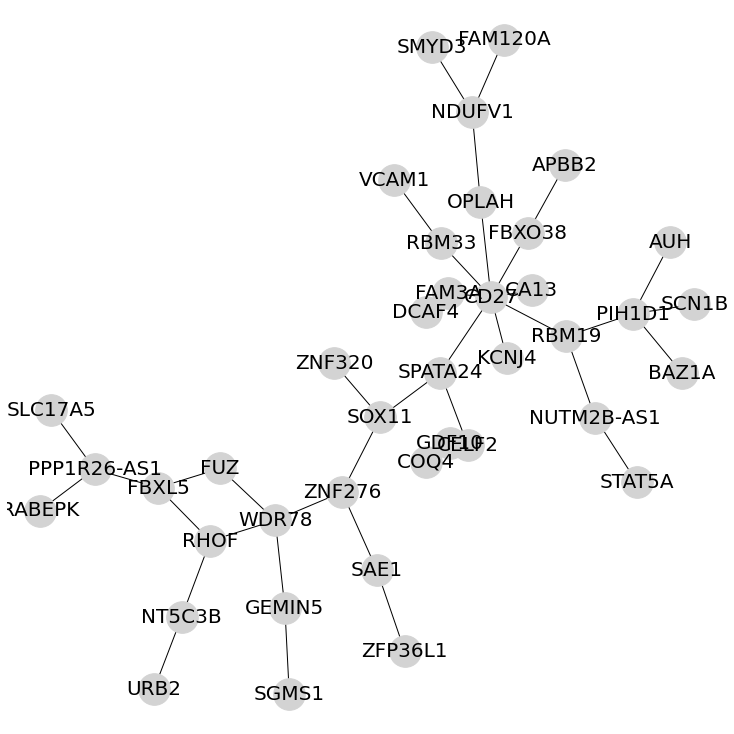

Left bottom corner: SLC17A5 [ 69.44491143 673.09118904]
Right top corner: STAT5A [1053.28174228  794.22934731]
stdout>
======= PASS 1    =========
BAZ1A
Old (x,y) = 1128.8741,610.0479
New (x,y) = 1128.8741,610.0479
CD27
Old (x,y) = 808.0678,483.0058
New (x,y) = 808.0678,483.0058
STAT5A
Old (x,y) = 1053.2817,794.2294
New (x,y) = 1053.2817,794.2294
APBB2
Old (x,y) = 932.801,260.79993
New (x,y) = 932.801,260.79993
OPLAH
Old (x,y) = 790.34564,322.8319
New (x,y) = 790.34564,322.8319
FAM120A
Old (x,y) = 829.7304,50.0
New (x,y) = 829.7304,50.0
FBXL5
Old (x,y) = 248.64749,803.0959
New (x,y) = 248.64749,803.0959
AUH
Old (x,y) = 1109.7069,391.07666
New (x,y) = 1109.7069,391.07666
DCAF4
Old (x,y) = 698.31445,507.55048
New (x,y) = 698.31445,507.55048
RBM33
Old (x,y) = 723.6446,392.40564
New (x,y) = 723.6446,392.40564
RABEPK
Old (x,y) = 50.0,841.58844
New (x,y) = 50.0,841.58844
PPP1R26-AS1
Old (x,y) = 142.0471,772.2698
New (x,y) = 142.0471,772.2698
SMYD3
Old (x,y) = 708.4247,62.351166
New (x,y) = 7

In [62]:
## Convert single file

#folder = '/mnt/c/Users/zinovyev/Google Drive/iPC_CURIE/Networks/Summa_Forget_subnetworks_n10+_inflation_2/'
folder = '/mnt/c/Users/zinovyev/Google Drive/iPC_CURIE/Networks/MB_Forget_RNASeq/'
folder = '/mnt/c/Users/zinovyev/Google Drive/iPC_CURIE/Networks/Ewing_Postel_Vinay_RNAseq/'
fn = 'Ewing_Postel_Vinay_RNAseq_module05.cyjs'
path_2_binom = '/mnt/c/MyPrograms/BiNoM2014/BiNoM_all.jar'

convert_cyjs2celldesigner(folder,fn,path_2_binom,final_name=fn.replace('Ewing','ES'),figsize=10)


['desktop.ini', 'Ewing_Postel_Vinay_RNAseq_module00.cyjs', 'Ewing_Postel_Vinay_RNAseq_module01.cyjs', 'Ewing_Postel_Vinay_RNAseq_module01.sif', 'Ewing_Postel_Vinay_RNAseq_module02.cyjs', 'Ewing_Postel_Vinay_RNAseq_module03.cyjs', 'Ewing_Postel_Vinay_RNAseq_module04.cyjs', 'Ewing_Postel_Vinay_RNAseq_module05.cyjs', 'Ewing_Postel_Vinay_RNAseq_module06.cyjs', 'Ewing_Postel_Vinay_RNAseq_module07.cyjs', 'Ewing_Postel_Vinay_RNAseq_module08.cyjs', 'Ewing_Postel_Vinay_RNAseq_module09.cyjs', 'Ewing_Postel_Vinay_RNAseq_module10.cyjs', 'Ewing_Postel_Vinay_RNAseq_module11.cyjs', 'Ewing_Postel_Vinay_RNAseq_module12.cyjs', 'Ewing_Postel_Vinay_RNAseq_module13.cyjs', 'Ewing_Postel_Vinay_RNAseq_module14.cyjs', 'Ewing_Postel_Vinay_RNAseq_module15.cyjs', 'Ewing_Postel_Vinay_RNAseq_module16.cyjs', 'Ewing_Postel_Vinay_RNAseq_module17.cyjs', 'Ewing_Postel_Vinay_RNAseq_module18.cyjs', 'Ewing_Postel_Vinay_RNAseq_module19.cyjs', 'Ewing_Postel_Vinay_RNAseq_module20.cyjs', 'Ewing_Postel_Vinay_RNAseq_module21.cyj

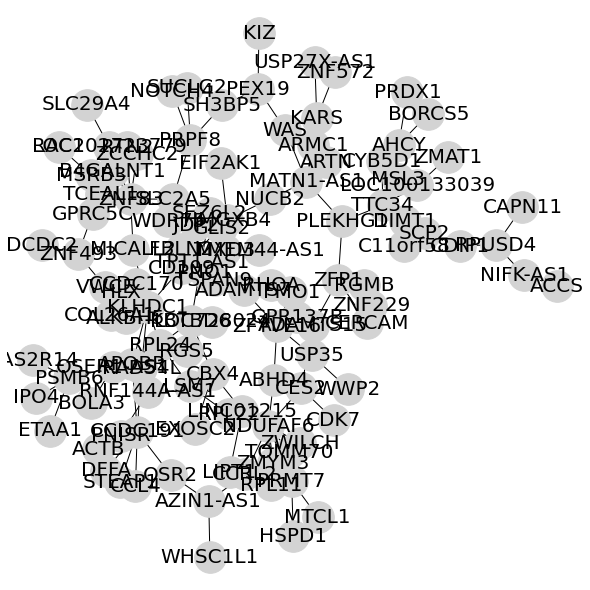

Left bottom corner: SLC29A4 [162.06388379 200.24722458]
Right top corner: ACCS [1150.          580.93394994]
stdout>
======= PASS 1    =========
SH3BP5
Old (x,y) = 447.09607,202.29086
New (x,y) = 447.09607,202.29086
RHOA
Old (x,y) = 549.40466,579.0035
New (x,y) = 549.40466,579.0035
AHCY
Old (x,y) = 817.41016,284.7242
New (x,y) = 817.41016,284.7242
ARTN
Old (x,y) = 665.4141,320.33606
New (x,y) = 665.4141,320.33606
CCDC170
Old (x,y) = 266.49377,576.5831
New (x,y) = 266.49377,576.5831
B4GALNT1
Old (x,y) = 216.72029,339.878
New (x,y) = 216.72029,339.878
RGMB
Old (x,y) = 744.99133,579.5089
New (x,y) = 744.99133,579.5089
IPO4
Old (x,y) = 56.497425,815.7777
New (x,y) = 56.497425,815.7777
SCP2
Old (x,y) = 871.77155,469.6886
New (x,y) = 871.77155,469.6886
GPR137B
Old (x,y) = 604.04877,646.43964
New (x,y) = 604.04877,646.43964
PLEKHG1
Old (x,y) = 698.80884,445.43442
New (x,y) = 698.80884,445.43442
ZNF83
Old (x,y) = 254.04791,398.9242
New (x,y) = 254.04791,398.9242
WWP2
Old (x,y) = 711.3805,797.4

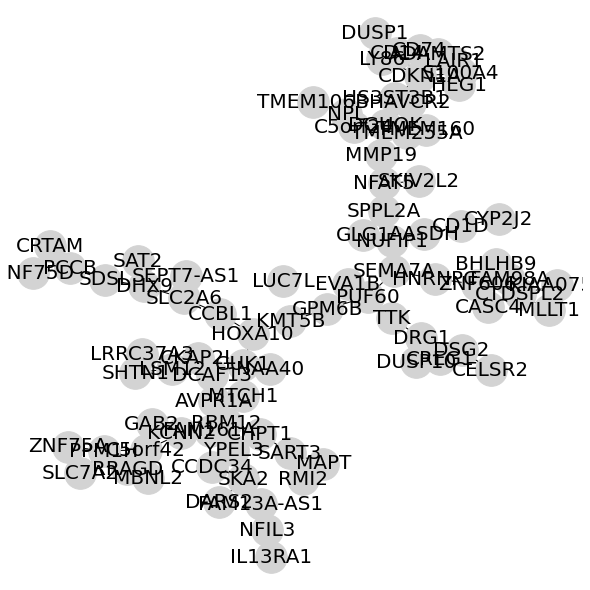

Left bottom corner: CRTAM [ 84.4612957  497.61715707]
Right top corner: CELSR2 [1010.60932376  757.89535476]
stdout>
======= PASS 1    =========
ZNF606
Old (x,y) = 982.4909,578.5006
New (x,y) = 982.4909,578.5006
HEG1
Old (x,y) = 943.04565,159.08203
New (x,y) = 943.04565,159.08203
SLC2A6
Old (x,y) = 365.69696,607.37524
New (x,y) = 365.69696,607.37524
HNRNPC
Old (x,y) = 893.6019,566.0704
New (x,y) = 893.6019,566.0704
RBM12
Old (x,y) = 455.44897,868.86926
New (x,y) = 455.44897,868.86926
CKAP2L
Old (x,y) = 395.04123,733.5512
New (x,y) = 395.04123,733.5512
LAIR1
Old (x,y) = 933.5877,109.94554
New (x,y) = 933.5877,109.94554
SDSL
Old (x,y) = 200.0857,567.8903
New (x,y) = 200.0857,567.8903
DGUOK
Old (x,y) = 788.00214,243.12436
New (x,y) = 788.00214,243.12436
DARS2
Old (x,y) = 440.7335,1034.8916
New (x,y) = 440.7335,1034.8916
MAPT
Old (x,y) = 659.3617,954.437
New (x,y) = 659.3617,954.437
TMEM255A
Old (x,y) = 834.51904,260.58032
New (x,y) = 834.51904,260.58032
HS3ST3B1
Old (x,y) = 808.82715,187.

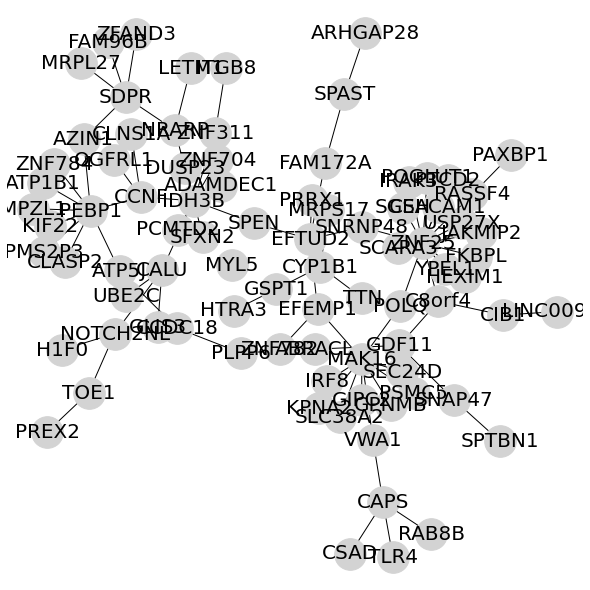

Left bottom corner: MRPL27 [150.86138398 113.633538  ]
Right top corner: RAB8B [ 886.13644408 1102.97319812]
stdout>
======= PASS 1    =========
HEXIM1
Old (x,y) = 957.3019,563.5717
New (x,y) = 957.3019,563.5717
EFTUD2
Old (x,y) = 630.97205,483.10764
New (x,y) = 630.97205,483.10764
ZNF782
Old (x,y) = 567.611,714.7437
New (x,y) = 567.611,714.7437
C8orf4
Old (x,y) = 900.8893,613.6023
New (x,y) = 900.8893,613.6023
LETM1
Old (x,y) = 380.76892,122.777466
New (x,y) = 380.76892,122.777466
USP27X
Old (x,y) = 949.96826,449.75507
New (x,y) = 949.96826,449.75507
CEACAM1
Old (x,y) = 899.3454,414.98807
New (x,y) = 899.3454,414.98807
SDPR
Old (x,y) = 244.34482,185.19315
New (x,y) = 244.34482,185.19315
MRPS17
Old (x,y) = 669.94916,422.45755
New (x,y) = 669.94916,422.45755
GDF11
Old (x,y) = 818.71405,706.36035
New (x,y) = 818.71405,706.36035
CSAD
Old (x,y) = 715.64307,1143.6384
New (x,y) = 715.64307,1143.6384
OGFRL1
Old (x,y) = 219.88246,317.55905
New (x,y) = 219.88246,317.55905
EFEMP1
Old (x,y) = 646

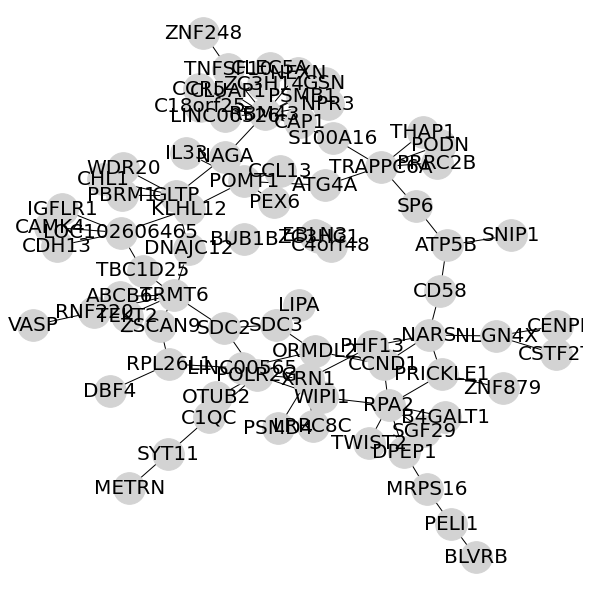

Left bottom corner: ZNF248 [407.18863624  50.        ]
Right top corner: BLVRB [ 979.09876463 1150.        ]
stdout>
======= PASS 1    =========
RPL26L1
Old (x,y) = 335.0671,745.34534
New (x,y) = 335.0671,745.34534
S100A16
Old (x,y) = 679.772,270.834
New (x,y) = 679.772,270.834
RNF220
Old (x,y) = 178.28398,635.9692
New (x,y) = 178.28398,635.9692
PHF13
Old (x,y) = 760.74554,707.78986
New (x,y) = 760.74554,707.78986
CAP1
Old (x,y) = 609.9977,236.86597
New (x,y) = 609.9977,236.86597
KLHL12
Old (x,y) = 376.7239,420.27344
New (x,y) = 376.7239,420.27344
NPR3
Old (x,y) = 669.32666,198.75125
New (x,y) = 669.32666,198.75125
PRRC2B
Old (x,y) = 897.5584,322.61835
New (x,y) = 897.5584,322.61835
C4orf48
Old (x,y) = 675.12695,496.59308
New (x,y) = 675.12695,496.59308
VASP
Old (x,y) = 50.0,663.83716
New (x,y) = 50.0,663.83716
WDR20
Old (x,y) = 238.8659,333.84238
New (x,y) = 238.8659,333.84238
CD58
Old (x,y) = 904.3336,591.5024
New (x,y) = 904.3336,591.5024
ZC3HC1
Old (x,y) = 649.0516,478.6806
New (x,

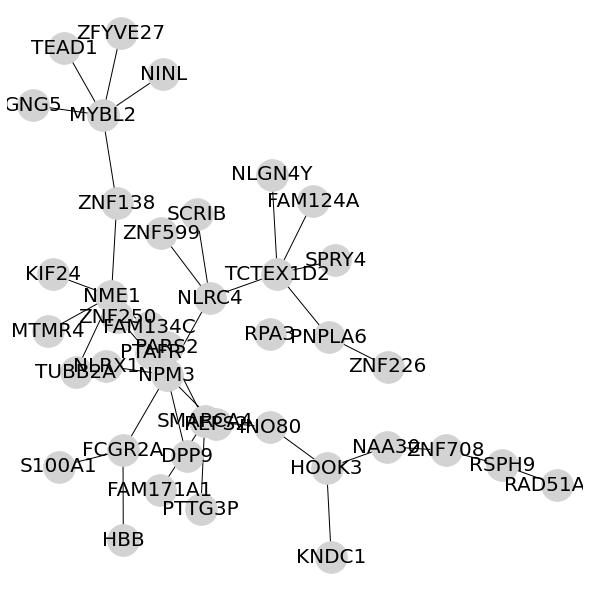

Left bottom corner: TEAD1 [115.14164516  81.03689862]
Right top corner: RAD51AP1 [1150.          999.04508317]
stdout>
======= PASS 1    =========
RPA3
Old (x,y) = 546.8143,681.935
New (x,y) = 546.8143,681.935
REPS2
Old (x,y) = 434.21503,872.148
New (x,y) = 434.21503,872.148
SPRY4
Old (x,y) = 684.2683,527.5154
New (x,y) = 684.2683,527.5154
ZFYVE27
Old (x,y) = 233.52655,50.0
New (x,y) = 233.52655,50.0
RSPH9
Old (x,y) = 1034.6136,957.3628
New (x,y) = 1034.6136,957.3628
SCRIB
Old (x,y) = 393.0884,430.78174
New (x,y) = 393.0884,430.78174
FCGR2A
Old (x,y) = 238.27489,927.02313
New (x,y) = 238.27489,927.02313
TEAD1
Old (x,y) = 115.14165,81.036896
New (x,y) = 115.14165,81.036896
KIF24
Old (x,y) = 90.513145,556.5768
New (x,y) = 90.513145,556.5768
MTMR4
Old (x,y) = 79.83257,676.817
New (x,y) = 79.83257,676.817
FAM124A
Old (x,y) = 637.76654,403.527
New (x,y) = 637.76654,403.527
GNG5
Old (x,y) = 50.0,202.21391
New (x,y) = 50.0,202.21391
FAM171A1
Old (x,y) = 315.5782,1010.2154
New (x,y) = 315.5782

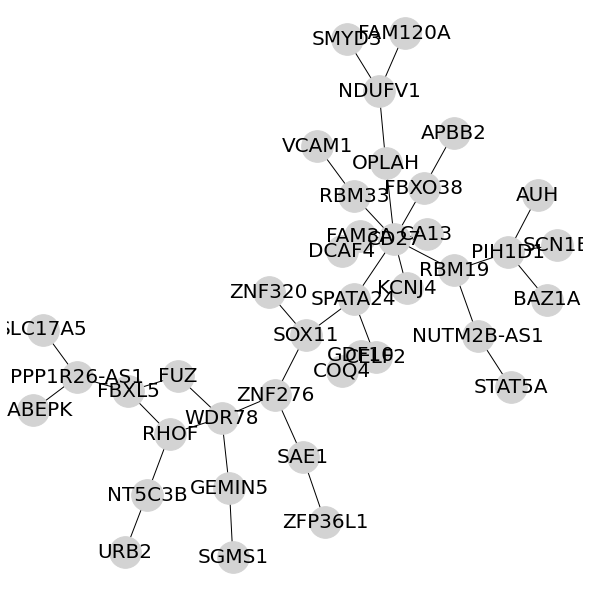

Left bottom corner: SLC17A5 [ 69.44491143 673.09118904]
Right top corner: STAT5A [1053.28174228  794.22934731]
stdout>
======= PASS 1    =========
BAZ1A
Old (x,y) = 1128.8741,610.0479
New (x,y) = 1128.8741,610.0479
CD27
Old (x,y) = 808.0678,483.0058
New (x,y) = 808.0678,483.0058
STAT5A
Old (x,y) = 1053.2817,794.2294
New (x,y) = 1053.2817,794.2294
APBB2
Old (x,y) = 932.801,260.79993
New (x,y) = 932.801,260.79993
OPLAH
Old (x,y) = 790.34564,322.8319
New (x,y) = 790.34564,322.8319
FAM120A
Old (x,y) = 829.7304,50.0
New (x,y) = 829.7304,50.0
FBXL5
Old (x,y) = 248.64749,803.0959
New (x,y) = 248.64749,803.0959
AUH
Old (x,y) = 1109.7069,391.07666
New (x,y) = 1109.7069,391.07666
DCAF4
Old (x,y) = 698.31445,507.55048
New (x,y) = 698.31445,507.55048
RBM33
Old (x,y) = 723.6446,392.40564
New (x,y) = 723.6446,392.40564
RABEPK
Old (x,y) = 50.0,841.58844
New (x,y) = 50.0,841.58844
PPP1R26-AS1
Old (x,y) = 142.0471,772.2698
New (x,y) = 142.0471,772.2698
SMYD3
Old (x,y) = 708.4247,62.351166
New (x,y) = 7

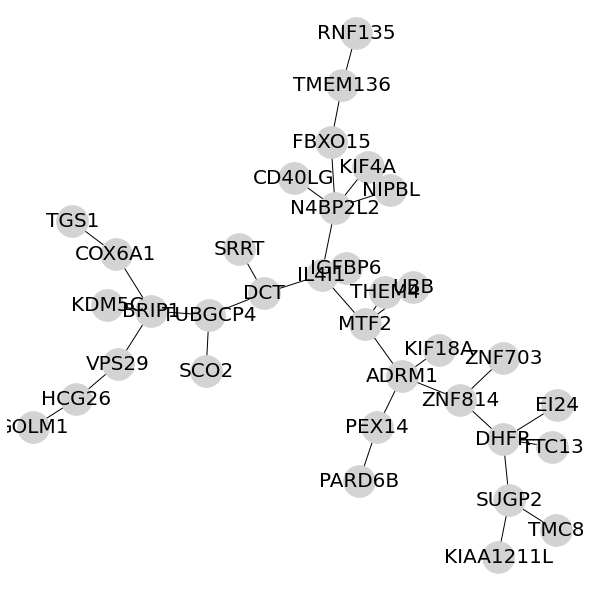

Left bottom corner: TGS1 [131.94782316 445.79234484]
Right top corner: TMC8 [1148.57994561 1094.88894045]
stdout>
======= PASS 1    =========
EI24
Old (x,y) = 1150.0,832.3349
New (x,y) = 1150.0,832.3349
ZNF814
Old (x,y) = 946.306,820.1751
New (x,y) = 946.306,820.1751
KIF18A
Old (x,y) = 901.8074,714.991
New (x,y) = 901.8074,714.991
DCT
Old (x,y) = 535.02844,596.87585
New (x,y) = 535.02844,596.87585
IL4I1
Old (x,y) = 655.2826,558.2981
New (x,y) = 655.2826,558.2981
SRRT
Old (x,y) = 482.54102,503.65997
New (x,y) = 482.54102,503.65997
TUBGCP4
Old (x,y) = 418.8922,642.6406
New (x,y) = 418.8922,642.6406
IGFBP6
Old (x,y) = 706.84863,543.7094
New (x,y) = 706.84863,543.7094
KIF4A
Old (x,y) = 751.9369,330.7991
New (x,y) = 751.9369,330.7991
TGS1
Old (x,y) = 131.94783,445.79236
New (x,y) = 131.94783,445.79236
ADRM1
Old (x,y) = 824.57916,771.45685
New (x,y) = 824.57916,771.45685
FBXO15
Old (x,y) = 675.2541,279.46823
New (x,y) = 675.2541,279.46823
ZNF703
Old (x,y) = 1037.2864,733.5251
New (x,y) = 103

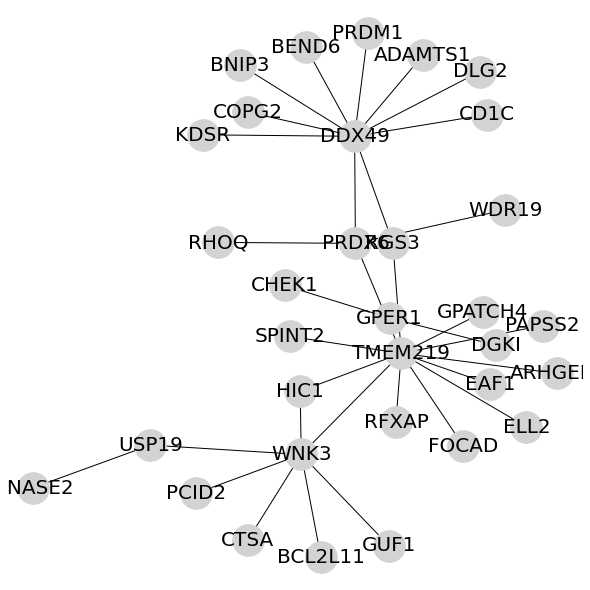

Left bottom corner: BNIP3 [483.45817588 116.427512  ]
Right top corner: ELL2 [1085.6803482   877.36925164]
stdout>
======= PASS 1    =========
CD1C
Old (x,y) = 1003.16034,221.37083
New (x,y) = 1003.16034,221.37083
PAPSS2
Old (x,y) = 1119.7068,664.5048
New (x,y) = 1119.7068,664.5048
DDX49
Old (x,y) = 724.8097,267.01993
New (x,y) = 724.8097,267.01993
ADAMTS1
Old (x,y) = 867.9846,96.97284
New (x,y) = 867.9846,96.97284
GPER1
Old (x,y) = 798.32117,648.77344
New (x,y) = 798.32117,648.77344
WNK3
Old (x,y) = 612.7373,935.424
New (x,y) = 612.7373,935.424
DLG2
Old (x,y) = 987.97876,131.03604
New (x,y) = 987.97876,131.03604
WDR19
Old (x,y) = 1040.9584,421.36523
New (x,y) = 1040.9584,421.36523
ARHGEF4
Old (x,y) = 1150.0,765.11896
New (x,y) = 1150.0,765.11896
GPATCH4
Old (x,y) = 994.29443,637.05615
New (x,y) = 994.29443,637.05615
PRDM1
Old (x,y) = 752.6287,50.0
New (x,y) = 752.6287,50.0
RNASE2
Old (x,y) = 50.0,1005.10254
New (x,y) = 50.0,1005.10254
TMEM219
Old (x,y) = 822.79755,723.0067
New (x,y) =

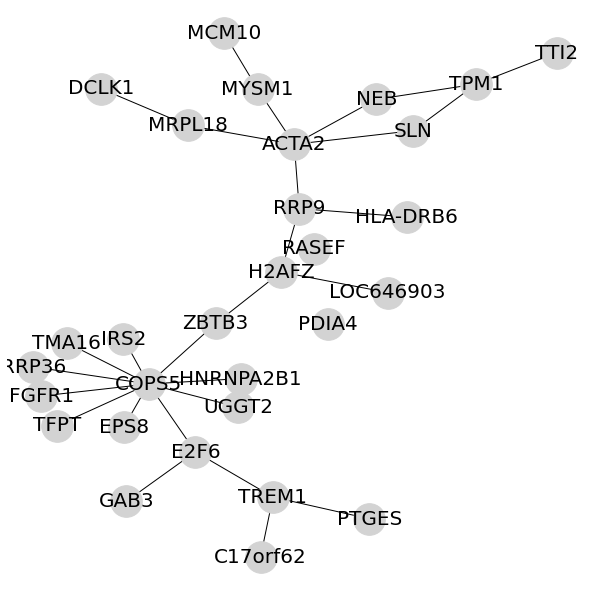

Left bottom corner: DCLK1 [191.42804906 166.7799699 ]
Right top corner: PTGES [ 756.04613215 1070.6444027 ]
stdout>
======= PASS 1    =========
ZBTB3
Old (x,y) = 433.0761,660.11597
New (x,y) = 433.0761,660.11597
HLA-DRB6
Old (x,y) = 834.2605,436.39362
New (x,y) = 834.2605,436.39362
LOC646903
Old (x,y) = 794.2056,595.25635
New (x,y) = 794.2056,595.25635
TREM1
Old (x,y) = 553.2767,1024.8542
New (x,y) = 553.2767,1024.8542
RASEF
Old (x,y) = 639.5868,502.84415
New (x,y) = 639.5868,502.84415
HNRNPA2B1
Old (x,y) = 485.34375,776.0849
New (x,y) = 485.34375,776.0849
TTI2
Old (x,y) = 1150.0,91.26828
New (x,y) = 1150.0,91.26828
IRS2
Old (x,y) = 239.17538,692.1545
New (x,y) = 239.17538,692.1545
ACTA2
Old (x,y) = 598.04663,283.82657
New (x,y) = 598.04663,283.82657
DCLK1
Old (x,y) = 191.42805,166.77997
New (x,y) = 191.42805,166.77997
SLN
Old (x,y) = 847.9156,255.1782
New (x,y) = 847.9156,255.1782
TMA16
Old (x,y) = 119.99834,700.4952
New (x,y) = 119.99834,700.4952
RRP36
Old (x,y) = 50.0,751.4483
New (

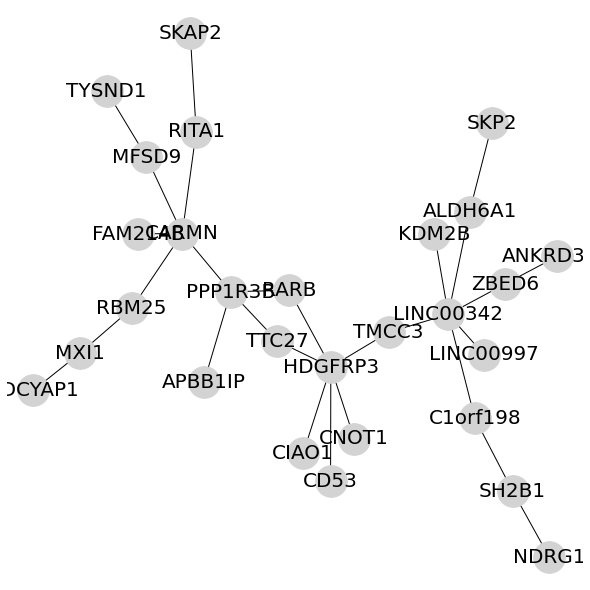

Left bottom corner: TYSND1 [203.82519009 171.81746015]
Right top corner: NDRG1 [1133.12073172 1150.        ]
stdout>
======= PASS 1    =========
KDM2B
Old (x,y) = 892.3365,472.4498
New (x,y) = 892.3365,472.4498
CNOT1
Old (x,y) = 723.9676,902.0074
New (x,y) = 723.9676,902.0074
SKP2
Old (x,y) = 1014.31305,238.61644
New (x,y) = 1014.31305,238.61644
HDGFRP3
Old (x,y) = 674.83307,751.7121
New (x,y) = 674.83307,751.7121
FAM214B
Old (x,y) = 269.46454,471.93405
New (x,y) = 269.46454,471.93405
TYSND1
Old (x,y) = 203.8252,171.81746
New (x,y) = 203.8252,171.81746
SKAP2
Old (x,y) = 379.34732,50.0
New (x,y) = 379.34732,50.0
ADCYAP1
Old (x,y) = 50.0,800.76105
New (x,y) = 50.0,800.76105
C1orf198
Old (x,y) = 977.327,859.34937
New (x,y) = 977.327,859.34937
LINC00342
Old (x,y) = 921.6583,641.147
New (x,y) = 921.6583,641.147
MFSD9
Old (x,y) = 287.32065,310.1535
New (x,y) = 287.32065,310.1535
TMCC3
Old (x,y) = 796.29614,678.7664
New (x,y) = 796.29614,678.7664
CARMN
Old (x,y) = 362.7188,471.29996
New (x,y)

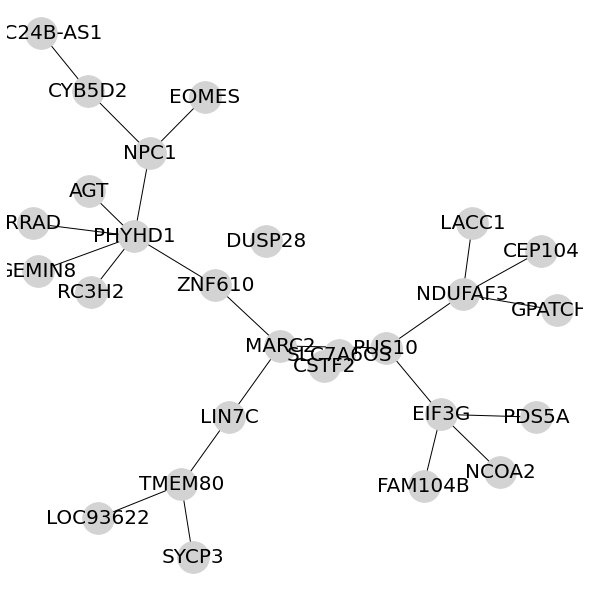

Left bottom corner: SEC24B-AS1 [65.78064477 50.        ]
Right top corner: NCOA2 [1030.94770493  972.84478227]
stdout>
======= PASS 1    =========
NCOA2
Old (x,y) = 1030.9478,972.8448
New (x,y) = 1030.9478,972.8448
RC3H2
Old (x,y) = 170.70328,593.99835
New (x,y) = 170.70328,593.99835
PUS10
Old (x,y) = 790.20544,711.67365
New (x,y) = 790.20544,711.67365
CEP104
Old (x,y) = 1116.4604,507.74533
New (x,y) = 1116.4604,507.74533
NPC1
Old (x,y) = 294.1643,302.1232
New (x,y) = 294.1643,302.1232
PDS5A
Old (x,y) = 1105.8602,856.9839
New (x,y) = 1105.8602,856.9839
AGT
Old (x,y) = 165.88243,382.92413
New (x,y) = 165.88243,382.92413
DUSP28
Old (x,y) = 538.0899,486.15305
New (x,y) = 538.0899,486.15305
EOMES
Old (x,y) = 410.36234,184.44104
New (x,y) = 410.36234,184.44104
LACC1
Old (x,y) = 972.39386,449.88666
New (x,y) = 972.39386,449.88666
MARC2
Old (x,y) = 568.54346,707.53217
New (x,y) = 568.54346,707.53217
LOC93622
Old (x,y) = 185.96684,1068.6506
New (x,y) = 185.96684,1068.6506
ZNF610
Old (x,y) = 43

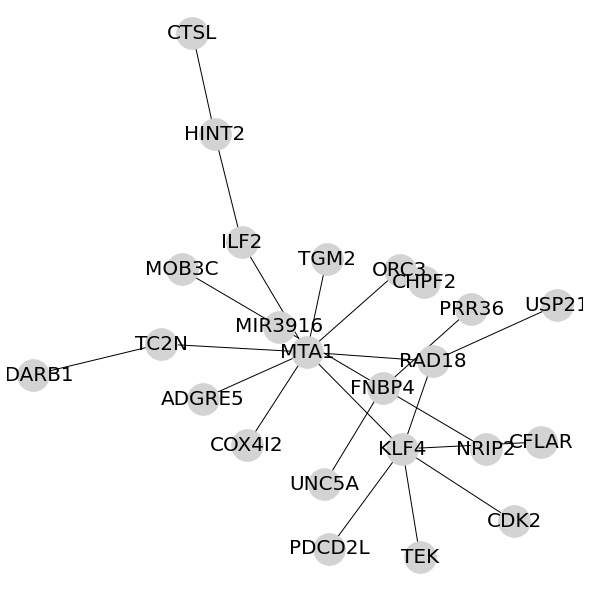

Left bottom corner: CTSL [384.25041147  50.        ]
Right top corner: CDK2 [1059.84684068 1075.95212518]
stdout>
======= PASS 1    =========
CDK2
Old (x,y) = 1059.8468,1075.9521
New (x,y) = 1059.8468,1075.9521
CFLAR
Old (x,y) = 1116.079,909.0664
New (x,y) = 1116.079,909.0664
USP21
Old (x,y) = 1150.0,621.24603
New (x,y) = 1150.0,621.24603
CHPF2
Old (x,y) = 871.1266,573.4919
New (x,y) = 871.1266,573.4919
PRR36
Old (x,y) = 969.741,629.11945
New (x,y) = 969.741,629.11945
TC2N
Old (x,y) = 318.44766,703.2384
New (x,y) = 318.44766,703.2384
MOB3C
Old (x,y) = 361.59848,546.77997
New (x,y) = 361.59848,546.77997
CTSL
Old (x,y) = 384.2504,50.0
New (x,y) = 384.2504,50.0
ILF2
Old (x,y) = 487.31653,489.07846
New (x,y) = 487.31653,489.07846
ORC3
Old (x,y) = 819.65826,548.0213
New (x,y) = 819.65826,548.0213
ADGRE5
Old (x,y) = 405.8463,818.2315
New (x,y) = 405.8463,818.2315
ADARB1
Old (x,y) = 50.0,768.0167
New (x,y) = 50.0,768.0167
COX4I2
Old (x,y) = 498.41696,915.4916
New (x,y) = 498.41696,915.4916
MT

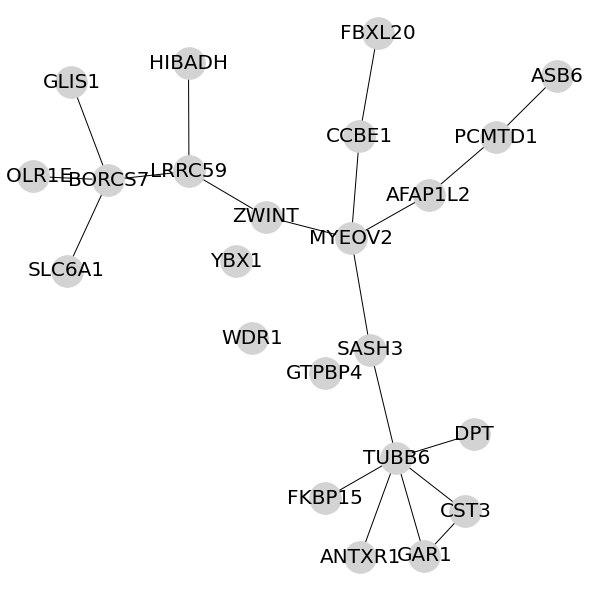

Left bottom corner: GLIS1 [129.98660816 152.96530492]
Right top corner: GAR1 [ 871.59689429 1147.75396073]
stdout>
======= PASS 1    =========
FBXL20
Old (x,y) = 773.1297,50.0
New (x,y) = 773.1297,50.0
DPT
Old (x,y) = 975.5031,891.8342
New (x,y) = 975.5031,891.8342
TUBB6
Old (x,y) = 812.4124,942.09033
New (x,y) = 812.4124,942.09033
ASB6
Old (x,y) = 1150.0,140.60269
New (x,y) = 1150.0,140.60269
MYEOV2
Old (x,y) = 717.7075,481.65155
New (x,y) = 717.7075,481.65155
GLIS1
Old (x,y) = 129.9866,152.9653
New (x,y) = 129.9866,152.9653
CCBE1
Old (x,y) = 734.96063,266.81424
New (x,y) = 734.96063,266.81424
BORCS7
Old (x,y) = 207.66945,358.68365
New (x,y) = 207.66945,358.68365
AFAP1L2
Old (x,y) = 880.20953,389.72885
New (x,y) = 880.20953,389.72885
ZWINT
Old (x,y) = 538.62823,435.54224
New (x,y) = 538.62823,435.54224
FKBP15
Old (x,y) = 663.3109,1027.6509
New (x,y) = 663.3109,1027.6509
YBX1
Old (x,y) = 475.94357,528.2356
New (x,y) = 475.94357,528.2356
POLR1E
Old (x,y) = 50.0,351.36108
New (x,y) = 50.

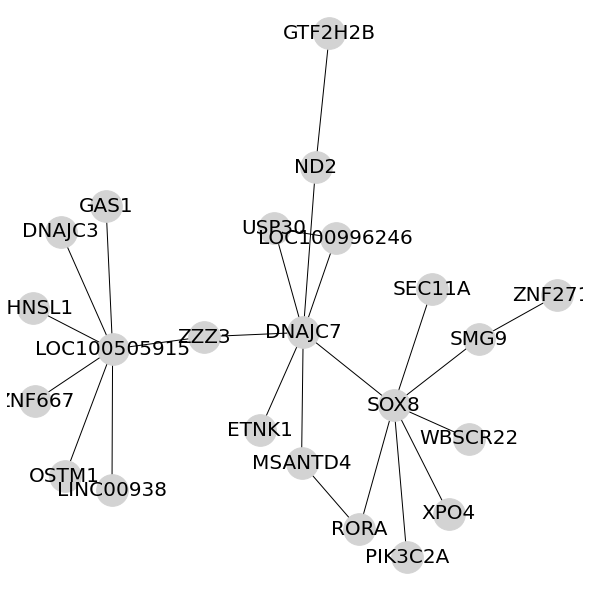

Left bottom corner: DNAJC3 [107.06791978 467.03389646]
Right top corner: PIK3C2A [ 834.67104529 1150.        ]
stdout>
======= PASS 1    =========
GAS1
Old (x,y) = 202.59363,414.12793
New (x,y) = 202.59363,414.12793
ND2
Old (x,y) = 642.89825,331.09802
New (x,y) = 642.89825,331.09802
LOC100996246
Old (x,y) = 685.1708,481.0501
New (x,y) = 685.1708,481.0501
ZNF271P
Old (x,y) = 1150.0,601.07776
New (x,y) = 1150.0,601.07776
SOX8
Old (x,y) = 807.2336,831.43335
New (x,y) = 807.2336,831.43335
DNAJC3
Old (x,y) = 107.06792,467.0339
New (x,y) = 107.06792,467.0339
THNSL1
Old (x,y) = 50.0,628.2636
New (x,y) = 50.0,628.2636
GTF2H2B
Old (x,y) = 671.9902,50.0
New (x,y) = 671.9902,50.0
SMG9
Old (x,y) = 985.78424,692.6827
New (x,y) = 985.78424,692.6827
ZNF667
Old (x,y) = 53.741623,822.80115
New (x,y) = 53.741623,822.80115
SEC11A
Old (x,y) = 887.77515,587.10297
New (x,y) = 887.77515,587.10297
MSANTD4
Old (x,y) = 613.3325,952.8684
New (x,y) = 613.3325,952.8684
OSTM1
Old (x,y) = 115.83574,981.2635
New (x,y

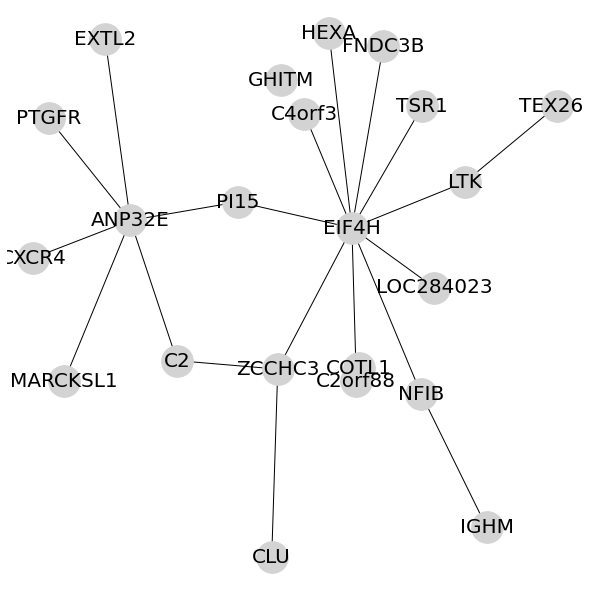

Left bottom corner: EXTL2 [200.93402159  63.63846721]
Right top corner: IGHM [1002.15049052 1088.20521548]
stdout>
======= PASS 1    =========
C2orf88
Old (x,y) = 728.3743,782.11127
New (x,y) = 728.3743,782.11127
EXTL2
Old (x,y) = 200.93402,63.638466
New (x,y) = 200.93402,63.638466
ANP32E
Old (x,y) = 253.67043,443.77298
New (x,y) = 253.67043,443.77298
TEX264
Old (x,y) = 1150.0,202.63438
New (x,y) = 1150.0,202.63438
ZCCHC3
Old (x,y) = 563.36285,756.0974
New (x,y) = 563.36285,756.0974
TSR1
Old (x,y) = 866.87946,204.25316
New (x,y) = 866.87946,204.25316
GHITM
Old (x,y) = 571.1976,149.74107
New (x,y) = 571.1976,149.74107
PTGFR
Old (x,y) = 82.075745,229.5433
New (x,y) = 82.075745,229.5433
FNDC3B
Old (x,y) = 784.7355,78.29747
New (x,y) = 784.7355,78.29747
NFIB
Old (x,y) = 864.54504,808.22375
New (x,y) = 864.54504,808.22375
HEXA
Old (x,y) = 670.9441,50.0
New (x,y) = 670.9441,50.0
CXCR4
Old (x,y) = 50.0,522.59467
New (x,y) = 50.0,522.59467
C4orf3
Old (x,y) = 619.5344,220.48308
New (x,y) = 619.

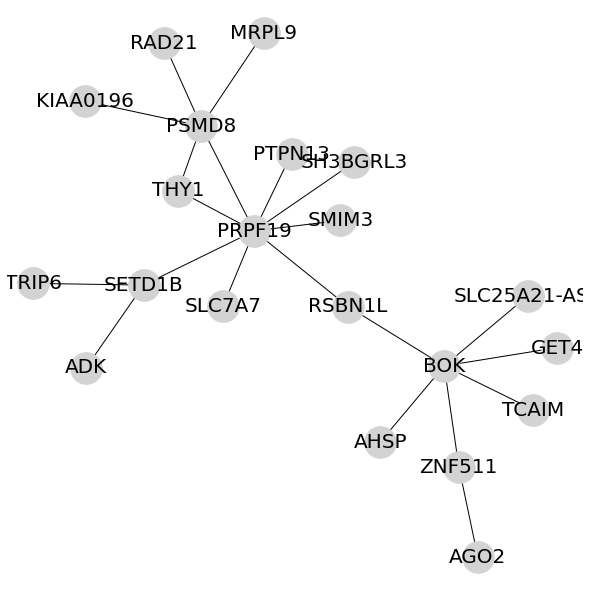

Left bottom corner: KIAA0196 [157.71631658 192.7746716 ]
Right top corner: AGO2 [ 983.49190232 1150.        ]
stdout>
======= PASS 1    =========
SLC25A21-AS1
Old (x,y) = 1088.3071,602.3691
New (x,y) = 1088.3071,602.3691
SMIM3
Old (x,y) = 694.7698,443.7294
New (x,y) = 694.7698,443.7294
RSBN1L
Old (x,y) = 710.74365,624.60004
New (x,y) = 710.74365,624.60004
SETD1B
Old (x,y) = 281.4514,579.5595
New (x,y) = 281.4514,579.5595
MRPL9
Old (x,y) = 533.63916,50.0
New (x,y) = 533.63916,50.0
THY1
Old (x,y) = 354.04117,380.9826
New (x,y) = 354.04117,380.9826
PSMD8
Old (x,y) = 402.5774,245.57175
New (x,y) = 402.5774,245.57175
SH3BGRL3
Old (x,y) = 723.17365,321.9042
New (x,y) = 723.17365,321.9042
PTPN13
Old (x,y) = 592.2325,303.56046
New (x,y) = 592.2325,303.56046
AHSP
Old (x,y) = 779.1503,908.69745
New (x,y) = 779.1503,908.69745
BOK
Old (x,y) = 912.9879,749.37994
New (x,y) = 912.9879,749.37994
ZNF511
Old (x,y) = 943.6824,961.0554
New (x,y) = 943.6824,961.0554
RAD21
Old (x,y) = 324.3328,71.254425
New

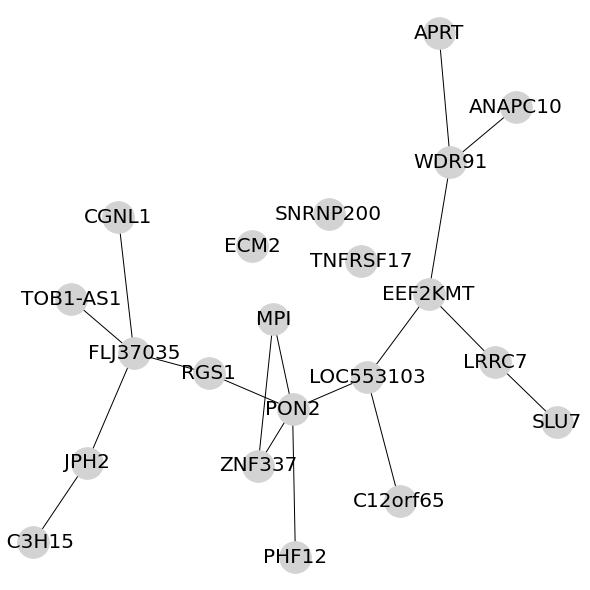

Left bottom corner: CGNL1 [228.40013562 435.81946041]
Right top corner: SLU7 [1150.          867.25982417]
stdout>
======= PASS 1    =========
SLU7
Old (x,y) = 1150.0,867.2598
New (x,y) = 1150.0,867.2598
PON2
Old (x,y) = 594.3861,840.20514
New (x,y) = 594.3861,840.20514
TNFRSF17
Old (x,y) = 737.77496,528.4905
New (x,y) = 737.77496,528.4905
LRRC7
Old (x,y) = 1019.9089,741.0814
New (x,y) = 1019.9089,741.0814
SNRNP200
Old (x,y) = 670.1465,430.4572
New (x,y) = 670.1465,430.4572
ANAPC10
Old (x,y) = 1063.5399,206.49976
New (x,y) = 1063.5399,206.49976
RGS1
Old (x,y) = 418.05872,764.7881
New (x,y) = 418.05872,764.7881
CGNL1
Old (x,y) = 228.40013,435.81946
New (x,y) = 228.40013,435.81946
ECM2
Old (x,y) = 509.05148,497.2777
New (x,y) = 509.05148,497.2777
JPH2
Old (x,y) = 162.63705,952.39307
New (x,y) = 162.63705,952.39307
APRT
Old (x,y) = 901.8731,50.0
New (x,y) = 901.8731,50.0
MPI
Old (x,y) = 554.0423,651.1332
New (x,y) = 554.0423,651.1332
PHF12
Old (x,y) = 600.4347,1150.0
New (x,y) = 600.4347,

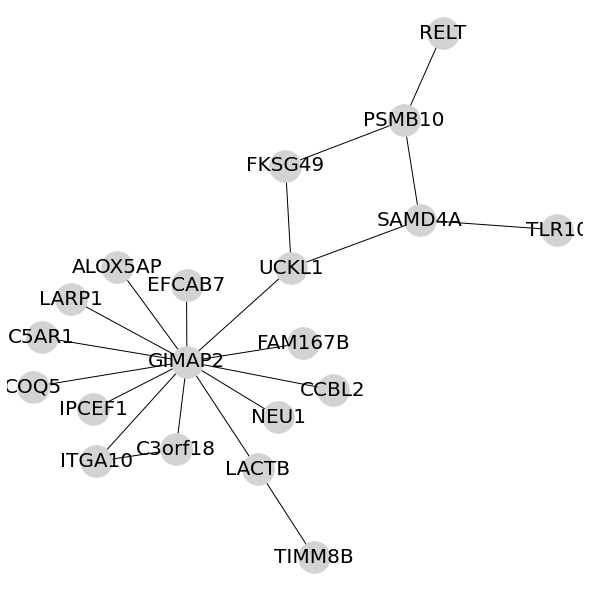

Left bottom corner: LARP1 [129.32916115 608.34417099]
Right top corner: TIMM8B [ 639.75582797 1150.        ]
stdout>
======= PASS 1    =========
UCKL1
Old (x,y) = 591.7425,543.0776
New (x,y) = 591.7425,543.0776
FAM167B
Old (x,y) = 617.14685,701.3325
New (x,y) = 617.14685,701.3325
EFCAB7
Old (x,y) = 371.68317,580.06287
New (x,y) = 371.68317,580.06287
TLR10
Old (x,y) = 1150.0,463.66287
New (x,y) = 1150.0,463.66287
PSMB10
Old (x,y) = 828.42816,233.3391
New (x,y) = 828.42816,233.3391
RELT
Old (x,y) = 909.8706,50.0
New (x,y) = 909.8706,50.0
SAMD4A
Old (x,y) = 861.9431,442.91083
New (x,y) = 861.9431,442.91083
ALOX5AP
Old (x,y) = 226.49745,540.76337
New (x,y) = 226.49745,540.76337
LARP1
Old (x,y) = 129.32916,608.3442
New (x,y) = 129.32916,608.3442
C5AR1
Old (x,y) = 67.19623,689.29736
New (x,y) = 67.19623,689.29736
COQ5
Old (x,y) = 50.0,793.08826
New (x,y) = 50.0,793.08826
IPCEF1
Old (x,y) = 176.10736,840.4117
New (x,y) = 176.10736,840.4117
GIMAP2
Old (x,y) = 372.5027,740.13495
New (x,y) = 372

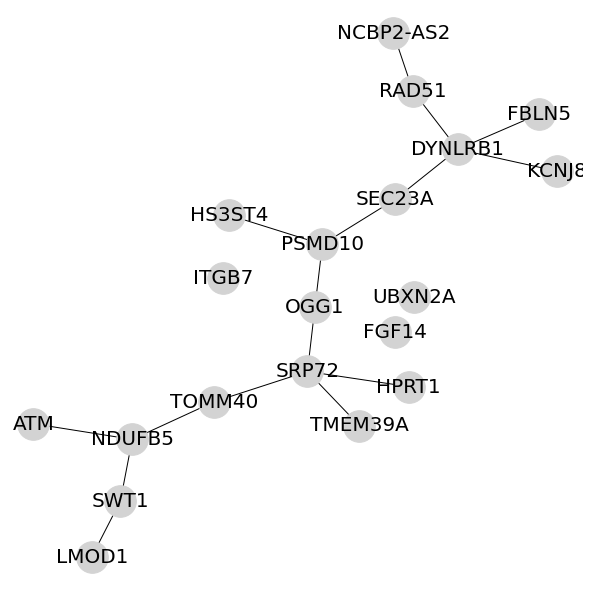

Left bottom corner: NCBP2-AS2 [806.21068879  50.        ]
Right top corner: HPRT1 [838.43093359 792.87712953]
stdout>
======= PASS 1    =========
UBXN2A
Old (x,y) = 849.7227,604.46735
New (x,y) = 849.7227,604.46735
DYNLRB1
Old (x,y) = 941.5537,294.27374
New (x,y) = 941.5537,294.27374
HPRT1
Old (x,y) = 838.4309,792.87714
New (x,y) = 838.4309,792.87714
KCNJ8
Old (x,y) = 1150.0,340.28247
New (x,y) = 1150.0,340.28247
RAD51
Old (x,y) = 847.2575,171.7294
New (x,y) = 847.2575,171.7294
SWT1
Old (x,y) = 232.81198,1032.9597
New (x,y) = 232.81198,1032.9597
SEC23A
Old (x,y) = 809.47046,399.74982
New (x,y) = 809.47046,399.74982
HS3ST4
Old (x,y) = 461.36267,432.68442
New (x,y) = 461.36267,432.68442
ATM
Old (x,y) = 50.0,870.79425
New (x,y) = 50.0,870.79425
ITGB7
Old (x,y) = 447.90436,565.61847
New (x,y) = 447.90436,565.61847
FBLN5
Old (x,y) = 1111.7264,220.61893
New (x,y) = 1111.7264,220.61893
TMEM39A
Old (x,y) = 734.57446,874.61487
New (x,y) = 734.57446,874.61487
NDUFB5
Old (x,y) = 257.69705,903.763

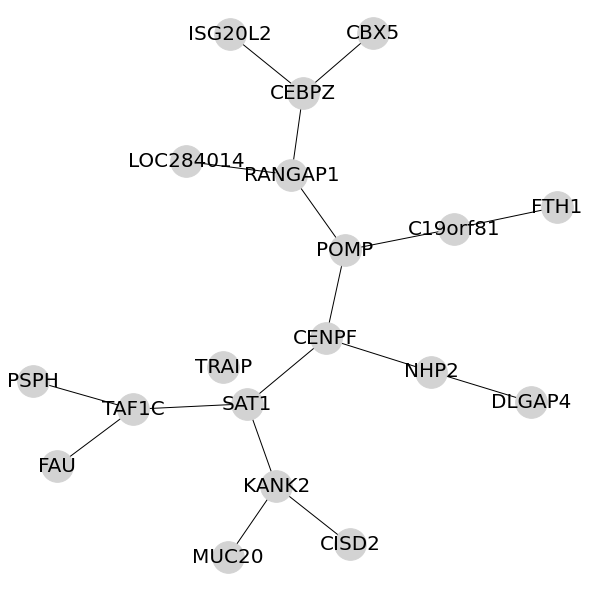

Left bottom corner: ISG20L2 [463.28195571  52.18799871]
Right top corner: DLGAP4 [1095.19722146  825.25030693]
stdout>
======= PASS 1    =========
C19orf81
Old (x,y) = 933.5882,460.9982
New (x,y) = 933.5882,460.9982
DLGAP4
Old (x,y) = 1095.1973,825.2503
New (x,y) = 1095.1973,825.2503
CENPF
Old (x,y) = 664.3132,691.34314
New (x,y) = 664.3132,691.34314
CBX5
Old (x,y) = 762.7557,50.0
New (x,y) = 762.7557,50.0
FTH1
Old (x,y) = 1150.0,415.53952
New (x,y) = 1150.0,415.53952
TAF1C
Old (x,y) = 259.4755,840.50104
New (x,y) = 259.4755,840.50104
PSPH
Old (x,y) = 50.0,780.77344
New (x,y) = 50.0,780.77344
ISG20L2
Old (x,y) = 463.28195,52.188
New (x,y) = 463.28195,52.188
LOC284014
Old (x,y) = 370.27472,319.64142
New (x,y) = 370.27472,319.64142
MUC20
Old (x,y) = 459.105,1150.0
New (x,y) = 459.105,1150.0
KANK2
Old (x,y) = 560.62354,1002.0773
New (x,y) = 560.62354,1002.0773
RANGAP1
Old (x,y) = 592.15015,348.16098
New (x,y) = 592.15015,348.16098
TRAIP
Old (x,y) = 448.67947,751.4292
New (x,y) = 448.67947

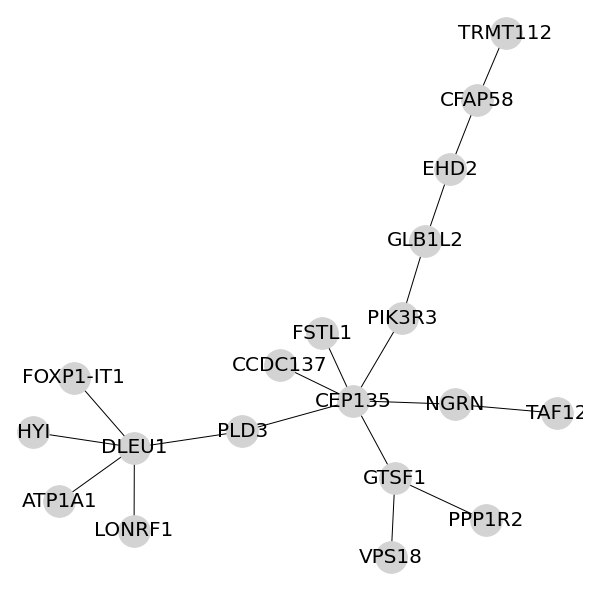

Left bottom corner: FOXP1-IT1 [134.40794204 773.88572185]
Right top corner: PPP1R2 [1000.26070622 1073.96326432]
stdout>
======= PASS 1    =========
PIK3R3
Old (x,y) = 824.4845,647.9089
New (x,y) = 824.4845,647.9089
GLB1L2
Old (x,y) = 873.49115,486.0122
New (x,y) = 873.49115,486.0122
CFAP58
Old (x,y) = 981.6786,191.74571
New (x,y) = 981.6786,191.74571
FSTL1
Old (x,y) = 656.7568,680.65625
New (x,y) = 656.7568,680.65625
CCDC137
Old (x,y) = 567.86456,747.6404
New (x,y) = 567.86456,747.6404
NGRN
Old (x,y) = 934.64624,829.8951
New (x,y) = 934.64624,829.8951
PLD3
Old (x,y) = 489.11285,886.8947
New (x,y) = 489.11285,886.8947
TRMT112
Old (x,y) = 1041.8461,50.0
New (x,y) = 1041.8461,50.0
GTSF1
Old (x,y) = 809.5324,985.1078
New (x,y) = 809.5324,985.1078
DLEU1
Old (x,y) = 262.11346,920.8094
New (x,y) = 262.11346,920.8094
FOXP1-IT1
Old (x,y) = 134.40794,773.88574
New (x,y) = 134.40794,773.88574
HYI
Old (x,y) = 50.0,888.857
New (x,y) = 50.0,888.857
PPP1R2
Old (x,y) = 1000.2607,1073.9633
New (x,y) =

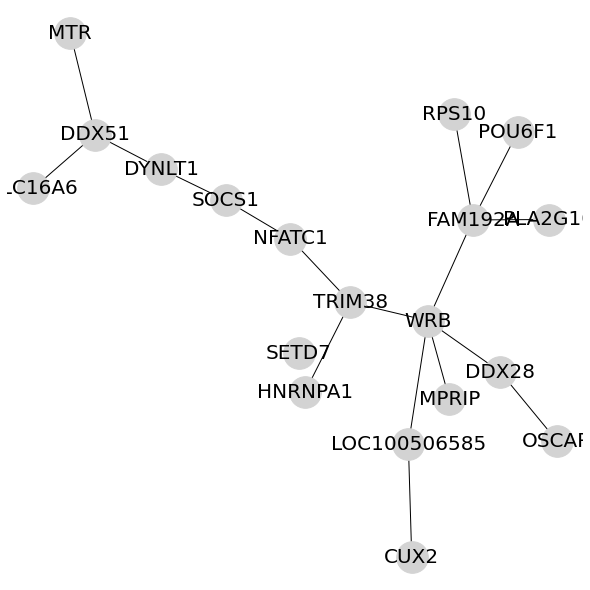

Left bottom corner: MTR [127.49066137  50.        ]
Right top corner: OSCAR [1150.          907.01454736]
stdout>
======= PASS 1    =========
FAM192A
Old (x,y) = 973.2272,442.7227
New (x,y) = 973.2272,442.7227
CUX2
Old (x,y) = 844.7755,1150.0
New (x,y) = 844.7755,1150.0
TRIM38
Old (x,y) = 715.8922,615.6388
New (x,y) = 715.8922,615.6388
DDX51
Old (x,y) = 179.78384,263.3647
New (x,y) = 179.78384,263.3647
DDX28
Old (x,y) = 1030.1409,761.4596
New (x,y) = 1030.1409,761.4596
POU6F1
Old (x,y) = 1067.2334,258.22726
New (x,y) = 1067.2334,258.22726
SLC16A6
Old (x,y) = 50.0,376.3905
New (x,y) = 50.0,376.3905
MPRIP
Old (x,y) = 923.89594,819.0486
New (x,y) = 923.89594,819.0486
DYNLT1
Old (x,y) = 318.52893,335.56287
New (x,y) = 318.52893,335.56287
PLA2G10
Old (x,y) = 1132.3075,441.8248
New (x,y) = 1132.3075,441.8248
NFATC1
Old (x,y) = 589.95386,481.8835
New (x,y) = 589.95386,481.8835
RPS10
Old (x,y) = 933.6275,219.93816
New (x,y) = 933.6275,219.93816
SETD7
Old (x,y) = 608.106,722.7797
New (x,y) = 60

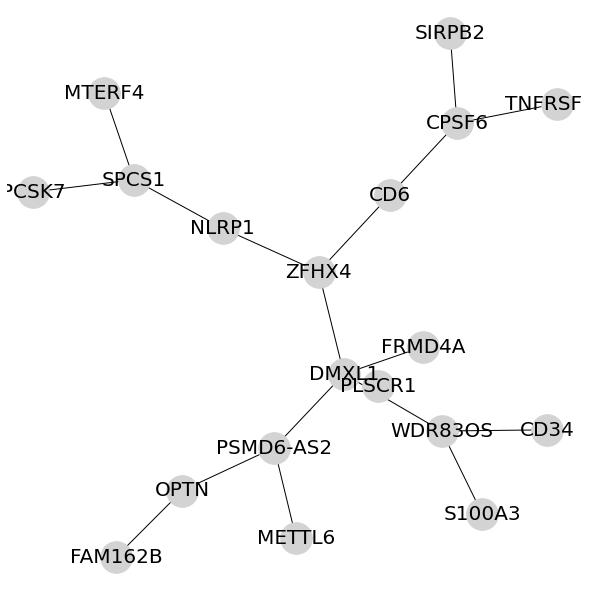

Left bottom corner: MTERF4 [199.19918912 176.02095429]
Right top corner: S100A3 [ 993.40649027 1061.18170012]
stdout>
======= PASS 1    =========
OPTN
Old (x,y) = 362.89862,1011.2354
New (x,y) = 362.89862,1011.2354
DMXL1
Old (x,y) = 702.3307,766.4055
New (x,y) = 702.3307,766.4055
TNFRSF1B
Old (x,y) = 1150.0,198.34735
New (x,y) = 1150.0,198.34735
ZFHX4
Old (x,y) = 649.059,551.27
New (x,y) = 649.059,551.27
NLRP1
Old (x,y) = 447.7927,460.4786
New (x,y) = 447.7927,460.4786
FRMD4A
Old (x,y) = 869.20105,708.8452
New (x,y) = 869.20105,708.8452
CD6
Old (x,y) = 798.8671,390.64832
New (x,y) = 798.8671,390.64832
SPCS1
Old (x,y) = 261.4187,358.27872
New (x,y) = 261.4187,358.27872
FAM162B
Old (x,y) = 224.4573,1150.0
New (x,y) = 224.4573,1150.0
PCSK7
Old (x,y) = 50.0,383.8984
New (x,y) = 50.0,383.8984
S100A3
Old (x,y) = 993.4065,1061.1816
New (x,y) = 993.4065,1061.1816
SIRPB2
Old (x,y) = 925.4114,50.0
New (x,y) = 925.4114,50.0
PSMD6-AS2
Old (x,y) = 555.88916,921.22723
New (x,y) = 555.88916,921.22723

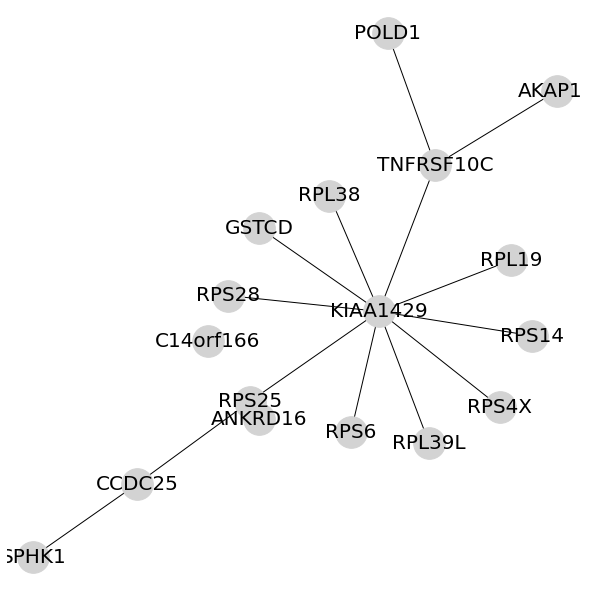

Left bottom corner: POLD1 [793.93491165  50.        ]
Right top corner: RPS4X [1029.55486385  835.28391373]
stdout>
======= PASS 1    =========
AKAP12
Old (x,y) = 1150.0,171.39967
New (x,y) = 1150.0,171.39967
KIAA1429
Old (x,y) = 776.2861,634.8182
New (x,y) = 776.2861,634.8182
RPL19
Old (x,y) = 1053.3217,527.46375
New (x,y) = 1053.3217,527.46375
TNFRSF10C
Old (x,y) = 894.2212,327.6535
New (x,y) = 894.2212,327.6535
POLD1
Old (x,y) = 793.93494,50.0
New (x,y) = 793.93494,50.0
RPL38
Old (x,y) = 671.89465,391.43234
New (x,y) = 671.89465,391.43234
CCDC25
Old (x,y) = 267.9181,997.3537
New (x,y) = 267.9181,997.3537
GSTCD
Old (x,y) = 524.62494,459.22504
New (x,y) = 524.62494,459.22504
RPS28
Old (x,y) = 458.76138,601.60284
New (x,y) = 458.76138,601.60284
C14orf166
Old (x,y) = 415.82428,696.96216
New (x,y) = 415.82428,696.96216
RPS25
Old (x,y) = 504.6877,824.16656
New (x,y) = 504.6877,824.16656
ANKRD16
Old (x,y) = 523.7391,861.0928
New (x,y) = 523.7391,861.0928
RPS6
Old (x,y) = 716.9532,888.7165


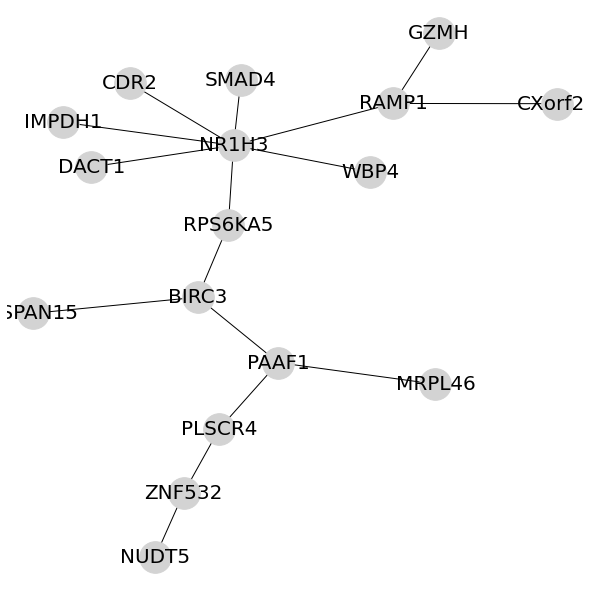

Left bottom corner: IMPDH1 [112.84671625 237.55637008]
Right top corner: MRPL46 [894.53285061 787.54916129]
stdout>
======= PASS 1    =========
PAAF1
Old (x,y) = 564.4229,742.5218
New (x,y) = 564.4229,742.5218
CXorf21
Old (x,y) = 1150.0,198.55846
New (x,y) = 1150.0,198.55846
GZMH
Old (x,y) = 901.5192,50.0
New (x,y) = 901.5192,50.0
DACT1
Old (x,y) = 171.59976,331.4169
New (x,y) = 171.59976,331.4169
IMPDH1
Old (x,y) = 112.84672,237.55637
New (x,y) = 112.84672,237.55637
PLSCR4
Old (x,y) = 440.7258,881.3172
New (x,y) = 440.7258,881.3172
RAMP1
Old (x,y) = 806.25616,198.02594
New (x,y) = 806.25616,198.02594
RPS6KA5
Old (x,y) = 459.63123,452.67438
New (x,y) = 459.63123,452.67438
TSPAN15
Old (x,y) = 50.0,638.81445
New (x,y) = 50.0,638.81445
CDR2
Old (x,y) = 252.90897,155.44136
New (x,y) = 252.90897,155.44136
ZNF532
Old (x,y) = 365.37906,1016.8443
New (x,y) = 365.37906,1016.8443
BIRC3
Old (x,y) = 395.36325,605.11346
New (x,y) = 395.36325,605.11346
WBP4
Old (x,y) = 758.1096,342.14957
New (x,y) =

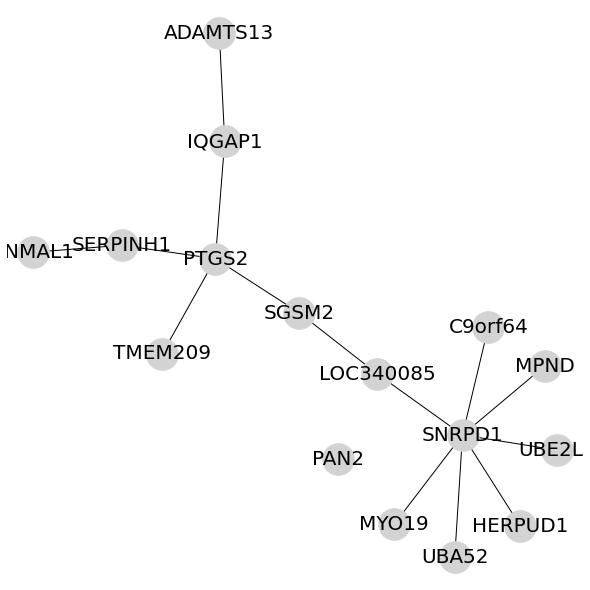

Left bottom corner: ADAMTS13 [440.58295402  50.        ]
Right top corner: HERPUD1 [1072.69459325 1085.19264457]
stdout>
======= PASS 1    =========
UBE2L6
Old (x,y) = 1150.0,926.3059
New (x,y) = 1150.0,926.3059
MPND
Old (x,y) = 1124.9803,748.74536
New (x,y) = 1124.9803,748.74536
PTGS2
Old (x,y) = 432.41592,524.2109
New (x,y) = 432.41592,524.2109
IQGAP1
Old (x,y) = 451.94864,277.7578
New (x,y) = 451.94864,277.7578
C9orf64
Old (x,y) = 1005.8089,667.3587
New (x,y) = 1005.8089,667.3587
ADAMTS13
Old (x,y) = 440.58295,50.0
New (x,y) = 440.58295,50.0
SERPINH1
Old (x,y) = 235.86069,495.96005
New (x,y) = 235.86069,495.96005
MYO19
Old (x,y) = 807.962,1081.91
New (x,y) = 807.962,1081.91
PNMAL1
Old (x,y) = 50.0,510.57294
New (x,y) = 50.0,510.57294
TMEM209
Old (x,y) = 320.85663,723.48645
New (x,y) = 320.85663,723.48645
UBA52
Old (x,y) = 935.19586,1150.0
New (x,y) = 935.19586,1150.0
SGSM2
Old (x,y) = 608.67487,637.9472
New (x,y) = 608.67487,637.9472
PAN2
Old (x,y) = 690.6665,945.6922
New (x,y) = 69

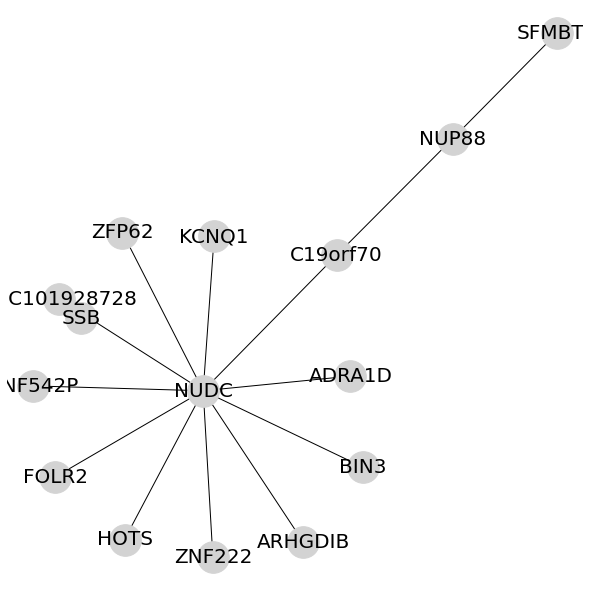

Left bottom corner: ZFP62 [237.05425928 469.21070933]
Right top corner: ARHGDIB [ 617.39687698 1120.1347516 ]
stdout>
======= PASS 1    =========
C19orf70
Old (x,y) = 686.8429,516.91223
New (x,y) = 686.8429,516.91223
NUP88
Old (x,y) = 930.4909,272.24606
New (x,y) = 930.4909,272.24606
KCNQ1
Old (x,y) = 429.82928,477.24377
New (x,y) = 429.82928,477.24377
SFMBT2
Old (x,y) = 1150.0,50.0
New (x,y) = 1150.0,50.0
NUDC
Old (x,y) = 406.7231,801.5847
New (x,y) = 406.7231,801.5847
ZFP62
Old (x,y) = 237.05426,469.21072
New (x,y) = 237.05426,469.21072
LOC101928728
Old (x,y) = 104.54649,608.6638
New (x,y) = 104.54649,608.6638
SSB
Old (x,y) = 150.54997,648.2105
New (x,y) = 150.54997,648.2105
ZNF542P
Old (x,y) = 50.0,791.3906
New (x,y) = 50.0,791.3906
FOLR2
Old (x,y) = 95.61909,982.7126
New (x,y) = 95.61909,982.7126
HOTS
Old (x,y) = 241.46802,1114.0935
New (x,y) = 241.46802,1114.0935
ZNF222
Old (x,y) = 427.01797,1150.0
New (x,y) = 427.01797,1150.0
ARHGDIB
Old (x,y) = 617.39685,1120.1348
New (x,y) = 61

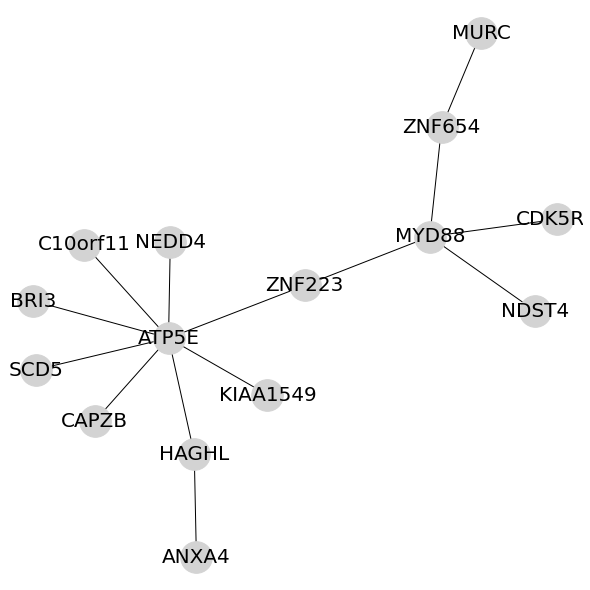

Left bottom corner: C10orf11 [156.70551188 494.45427104]
Right top corner: NDST4 [1103.31027141  633.49468764]
stdout>
======= PASS 1    =========
KIAA1549
Old (x,y) = 541.44147,809.8556
New (x,y) = 541.44147,809.8556
NDST4
Old (x,y) = 1103.3103,633.4947
New (x,y) = 1103.3103,633.4947
NEDD4
Old (x,y) = 337.62402,490.13126
New (x,y) = 337.62402,490.13126
C10orf11
Old (x,y) = 156.7055,494.45428
New (x,y) = 156.7055,494.45428
CDK5R1
Old (x,y) = 1150.0,441.30276
New (x,y) = 1150.0,441.30276
MURC
Old (x,y) = 990.2844,50.0
New (x,y) = 990.2844,50.0
BRI3
Old (x,y) = 50.0,612.8188
New (x,y) = 50.0,612.8188
SCD5
Old (x,y) = 55.833572,757.39526
New (x,y) = 55.833572,757.39526
HAGHL
Old (x,y) = 387.94052,934.23804
New (x,y) = 387.94052,934.23804
ZNF223
Old (x,y) = 620.12897,580.335
New (x,y) = 620.12897,580.335
CAPZB
Old (x,y) = 178.54663,865.67865
New (x,y) = 178.54663,865.67865
ANXA4
Old (x,y) = 392.40973,1150.0
New (x,y) = 392.40973,1150.0
ATP5E
Old (x,y) = 333.90634,691.02563
New (x,y) = 333.

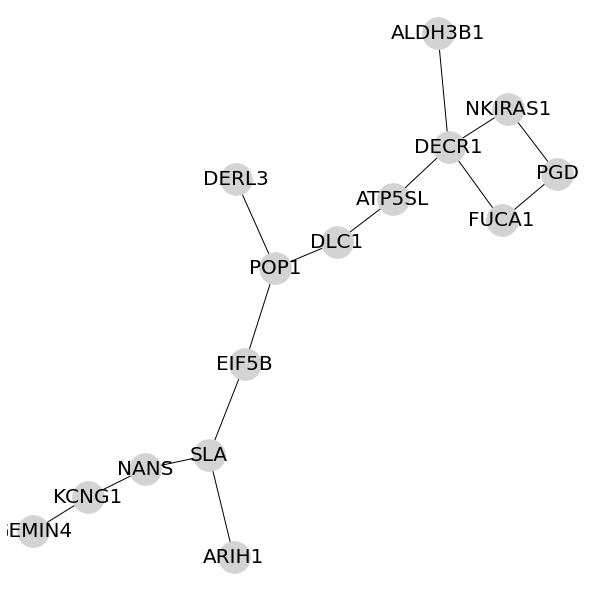

Left bottom corner: DERL3 [474.70377897 357.05780869]
Right top corner: ARIH1 [ 470.94477977 1150.        ]
stdout>
======= PASS 1    =========
DECR1
Old (x,y) = 922.282,289.6449
New (x,y) = 922.282,289.6449
POP1
Old (x,y) = 557.88354,543.7132
New (x,y) = 557.88354,543.7132
ATP5SL
Old (x,y) = 805.1453,399.41125
New (x,y) = 805.1453,399.41125
FUCA1
Old (x,y) = 1033.81,443.40775
New (x,y) = 1033.81,443.40775
DERL3
Old (x,y) = 474.70377,357.0578
New (x,y) = 474.70377,357.0578
ALDH3B1
Old (x,y) = 899.8025,50.0
New (x,y) = 899.8025,50.0
DLC1
Old (x,y) = 687.8095,489.1266
New (x,y) = 687.8095,489.1266
KCNG1
Old (x,y) = 164.79572,1024.8907
New (x,y) = 164.79572,1024.8907
NANS
Old (x,y) = 284.92566,965.3969
New (x,y) = 284.92566,965.3969
GEMIN4
Old (x,y) = 50.0,1096.1385
New (x,y) = 50.0,1096.1385
PGD
Old (x,y) = 1150.0,345.37598
New (x,y) = 1150.0,345.37598
ARIH1
Old (x,y) = 470.9448,1150.0
New (x,y) = 470.9448,1150.0
EIF5B
Old (x,y) = 493.92282,745.21924
New (x,y) = 493.92282,745.21924
SLA
O

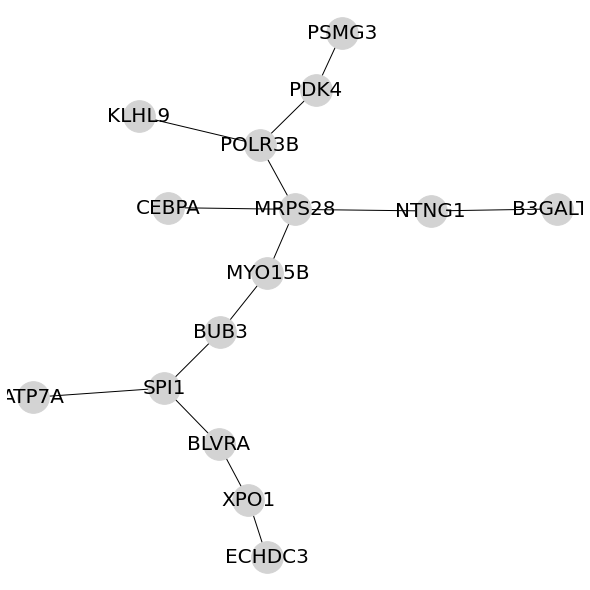

Left bottom corner: KLHL9 [270.96732592 224.28525525]
Right top corner: ECHDC3 [ 540.09626042 1150.        ]
stdout>
======= PASS 1    =========
B3GALT6
Old (x,y) = 1150.0,419.5641
New (x,y) = 1150.0,419.5641
PDK4
Old (x,y) = 643.0566,168.96751
New (x,y) = 643.0566,168.96751
ECHDC3
Old (x,y) = 540.09625,1150.0
New (x,y) = 540.09625,1150.0
PSMG3
Old (x,y) = 698.03864,50.0
New (x,y) = 698.03864,50.0
MYO15B
Old (x,y) = 541.80255,554.01227
New (x,y) = 541.80255,554.01227
CEBPA
Old (x,y) = 333.7568,416.81982
New (x,y) = 333.7568,416.81982
POLR3B
Old (x,y) = 525.39716,284.79425
New (x,y) = 525.39716,284.79425
ATP7A
Old (x,y) = 50.0,815.27875
New (x,y) = 50.0,815.27875
KLHL9
Old (x,y) = 270.96732,224.28525
New (x,y) = 270.96732,224.28525
BUB3
Old (x,y) = 442.67508,678.4278
New (x,y) = 442.67508,678.4278
SPI1
Old (x,y) = 324.9211,795.8565
New (x,y) = 324.9211,795.8565
BLVRA
Old (x,y) = 438.92252,913.1199
New (x,y) = 438.92252,913.1199
XPO1
Old (x,y) = 501.7722,1031.222
New (x,y) = 501.7722,103

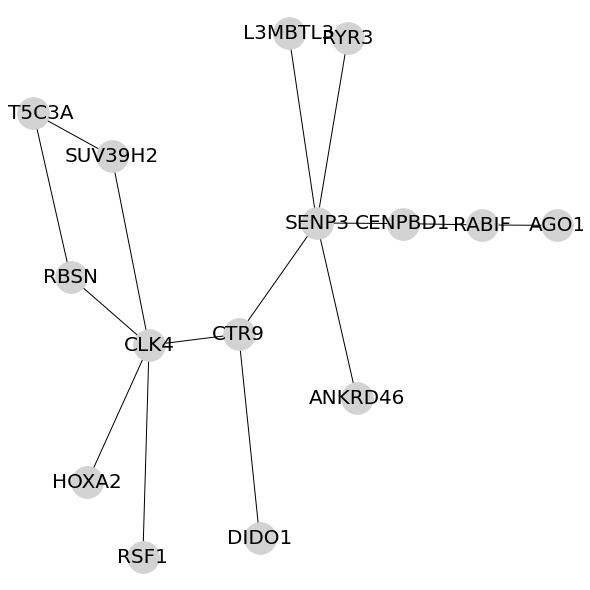

Left bottom corner: NT5C3A [ 50.         217.89728833]
Right top corner: DIDO1 [ 525.38068009 1110.4965532 ]
stdout>
======= PASS 1    =========
RYR3
Old (x,y) = 710.4492,60.39225
New (x,y) = 710.4492,60.39225
AGO1
Old (x,y) = 1150.0,454.19244
New (x,y) = 1150.0,454.19244
CENPBD1
Old (x,y) = 826.1351,450.40198
New (x,y) = 826.1351,450.40198
NT5C3A
Old (x,y) = 50.0,217.8973
New (x,y) = 50.0,217.8973
SENP3
Old (x,y) = 645.39886,449.08292
New (x,y) = 645.39886,449.08292
CLK4
Old (x,y) = 293.00473,706.086
New (x,y) = 293.00473,706.086
L3MBTL3
Old (x,y) = 586.1906,50.0
New (x,y) = 586.1906,50.0
HOXA2
Old (x,y) = 163.03009,993.5505
New (x,y) = 163.03009,993.5505
SUV39H2
Old (x,y) = 214.49774,308.54816
New (x,y) = 214.49774,308.54816
RBSN
Old (x,y) = 127.98615,562.23676
New (x,y) = 127.98615,562.23676
ANKRD46
Old (x,y) = 729.18066,816.75464
New (x,y) = 729.18066,816.75464
RSF1
Old (x,y) = 279.99854,1150.0
New (x,y) = 279.99854,1150.0
CTR9
Old (x,y) = 481.22763,682.56104
New (x,y) = 481.22763,

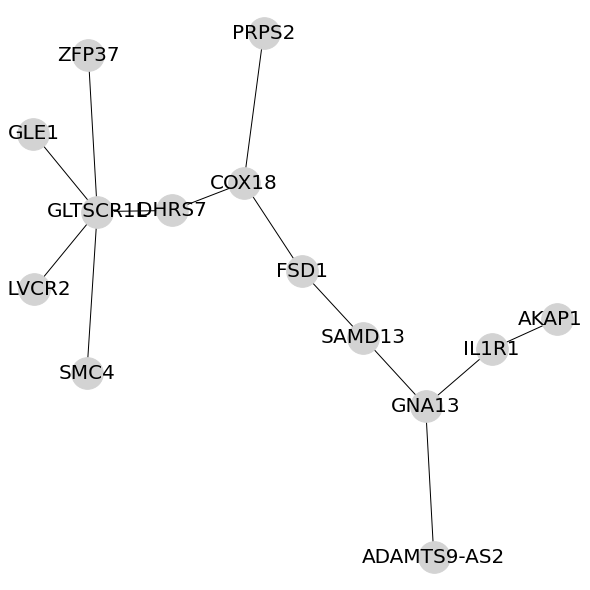

Left bottom corner: ZFP37 [165.487485    97.12339096]
Right top corner: ADAMTS9-AS2 [ 891.24780273 1150.        ]
stdout>
======= PASS 1    =========
SMC4
Old (x,y) = 162.30045,765.11816
New (x,y) = 162.30045,765.11816
COX18
Old (x,y) = 492.08322,364.624
New (x,y) = 492.08322,364.624
ADAMTS9-AS2
Old (x,y) = 891.2478,1150.0
New (x,y) = 891.2478,1150.0
DHRS7
Old (x,y) = 341.3062,422.80576
New (x,y) = 341.3062,422.80576
AKAP11
Old (x,y) = 1150.0,651.37604
New (x,y) = 1150.0,651.37604
GLTSCR1L
Old (x,y) = 184.19614,425.20837
New (x,y) = 184.19614,425.20837
FSD1
Old (x,y) = 613.89435,550.42194
New (x,y) = 613.89435,550.42194
ZFP37
Old (x,y) = 165.48749,97.12339
New (x,y) = 165.48749,97.12339
GLE1
Old (x,y) = 50.0,261.36166
New (x,y) = 50.0,261.36166
GNA13
Old (x,y) = 873.9194,833.13684
New (x,y) = 873.9194,833.13684
FLVCR2
Old (x,y) = 50.293102,588.54755
New (x,y) = 50.293102,588.54755
SAMD13
Old (x,y) = 742.6035,689.7987
New (x,y) = 742.6035,689.7987
IL1R1
Old (x,y) = 1012.6294,713.6684
Ne

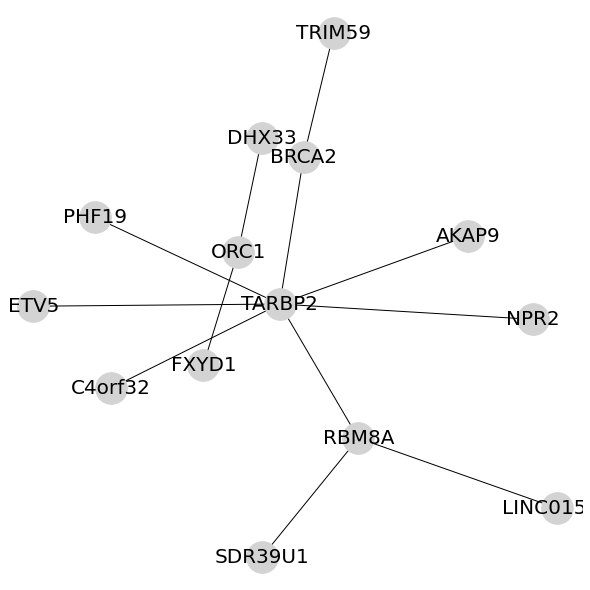

Left bottom corner: PHF19 [178.89074179 437.02655992]
Right top corner: LINC01560 [1150.         1048.26161701]
stdout>
======= PASS 1    =========
AKAP9
Old (x,y) = 963.2458,476.15036
New (x,y) = 963.2458,476.15036
ORC1
Old (x,y) = 480.13626,509.2673
New (x,y) = 480.13626,509.2673
TRIM59
Old (x,y) = 680.49365,50.0
New (x,y) = 680.49365,50.0
RBM8A
Old (x,y) = 732.71136,901.19464
New (x,y) = 732.71136,901.19464
PHF19
Old (x,y) = 178.89075,437.02655
New (x,y) = 178.89075,437.02655
DHX33
Old (x,y) = 530.27295,270.92038
New (x,y) = 530.27295,270.92038
ETV5
Old (x,y) = 50.0,623.9554
New (x,y) = 50.0,623.9554
FXYD1
Old (x,y) = 407.02963,747.50543
New (x,y) = 407.02963,747.50543
BRCA2
Old (x,y) = 617.8943,309.8192
New (x,y) = 617.8943,309.8192
TARBP2
Old (x,y) = 567.51166,619.4024
New (x,y) = 567.51166,619.4024
SDR39U1
Old (x,y) = 530.58356,1150.0
New (x,y) = 530.58356,1150.0
C4orf32
Old (x,y) = 212.30058,796.4022
New (x,y) = 212.30058,796.4022
LINC01560
Old (x,y) = 1150.0,1048.2616
New (x,y)

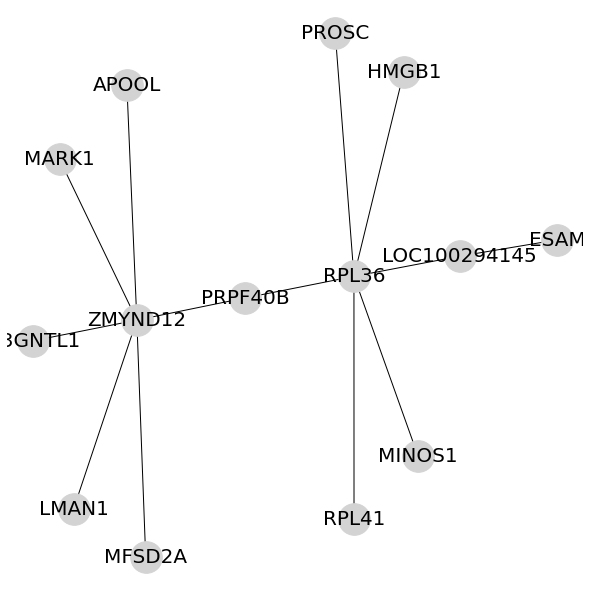

Left bottom corner: APOOL [246.41492848 160.2975513 ]
Right top corner: MINOS1 [858.4624903  939.61727593]
stdout>
======= PASS 1    =========
ESAM
Old (x,y) = 1150.0,484.56747
New (x,y) = 1150.0,484.56747
HMGB1
Old (x,y) = 828.33215,131.14474
New (x,y) = 828.33215,131.14474
PRPF40B
Old (x,y) = 494.5011,606.71844
New (x,y) = 494.5011,606.71844
APOOL
Old (x,y) = 246.41493,160.29755
New (x,y) = 246.41493,160.29755
PROSC
Old (x,y) = 684.05884,50.0
New (x,y) = 684.05884,50.0
RPL36
Old (x,y) = 723.40985,561.27765
New (x,y) = 723.40985,561.27765
MARK1
Old (x,y) = 104.94708,315.33963
New (x,y) = 104.94708,315.33963
B3GNTL1
Old (x,y) = 50.0,696.504
New (x,y) = 50.0,696.504
LOC100294145
Old (x,y) = 945.3105,518.97864
New (x,y) = 945.3105,518.97864
RPL41
Old (x,y) = 723.55316,1070.6451
New (x,y) = 723.55316,1070.6451
LMAN1
Old (x,y) = 134.54225,1049.4784
New (x,y) = 134.54225,1049.4784
MFSD2A
Old (x,y) = 285.89856,1150.0
New (x,y) = 285.89856,1150.0
ZMYND12
Old (x,y) = 267.28754,653.1087
New (x,

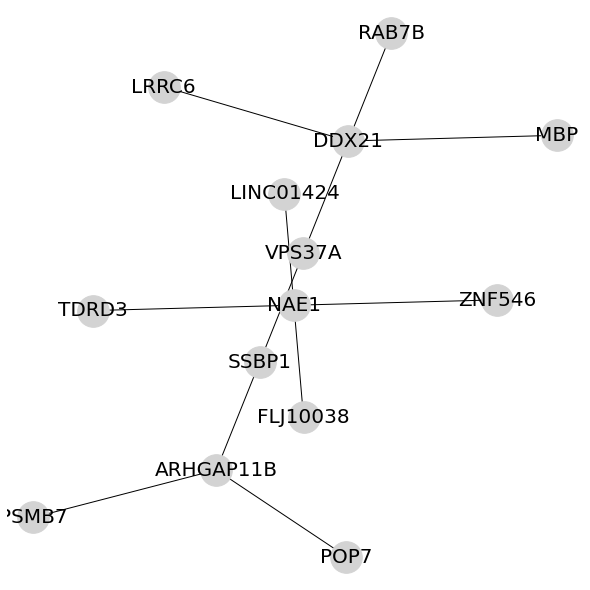

Left bottom corner: LRRC6 [323.56085511 162.77361357]
Right top corner: POP7 [ 707.48369569 1150.        ]
stdout>
======= PASS 1    =========
MBP
Old (x,y) = 1150.0,264.9436
New (x,y) = 1150.0,264.9436
NAE1
Old (x,y) = 597.2374,621.9325
New (x,y) = 597.2374,621.9325
SSBP1
Old (x,y) = 525.67114,740.8481
New (x,y) = 525.67114,740.8481
RAB7B
Old (x,y) = 802.22,50.0
New (x,y) = 802.22,50.0
VPS37A
Old (x,y) = 617.1661,512.35815
New (x,y) = 617.1661,512.35815
LINC01424
Old (x,y) = 577.3088,387.31598
New (x,y) = 577.3088,387.31598
LRRC6
Old (x,y) = 323.56085,162.77362
New (x,y) = 323.56085,162.77362
ARHGAP11B
Old (x,y) = 434.45087,967.9548
New (x,y) = 434.45087,967.9548
TDRD3
Old (x,y) = 175.7088,633.0947
New (x,y) = 175.7088,633.0947
PSMB7
Old (x,y) = 50.0,1067.7029
New (x,y) = 50.0,1067.7029
FLJ10038
Old (x,y) = 617.4922,856.68866
New (x,y) = 617.4922,856.68866
DDX21
Old (x,y) = 711.386,276.8976
New (x,y) = 711.386,276.8976
POP7
Old (x,y) = 707.4837,1150.0
New (x,y) = 707.4837,1150.0
ZNF54

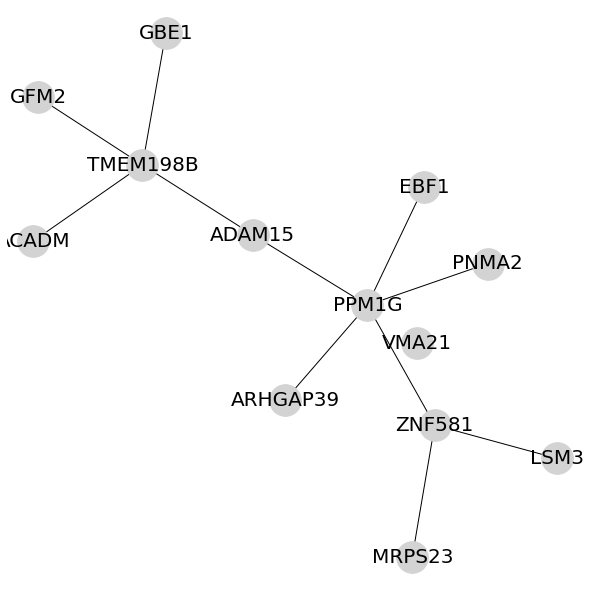

Left bottom corner: GFM2 [ 60.59491933 185.19362735]
Right top corner: LSM3 [1150.          943.77478214]
stdout>
======= PASS 1    =========
PNMA2
Old (x,y) = 1004.4134,534.31104
New (x,y) = 1004.4134,534.31104
LSM3
Old (x,y) = 1150.0,943.7748
New (x,y) = 1150.0,943.7748
ADAM15
Old (x,y) = 510.5047,473.73367
New (x,y) = 510.5047,473.73367
TMEM198B
Old (x,y) = 279.2166,327.17413
New (x,y) = 279.2166,327.17413
EBF1
Old (x,y) = 870.2599,372.99927
New (x,y) = 870.2599,372.99927
GBE1
Old (x,y) = 328.223,50.0
New (x,y) = 328.223,50.0
GFM2
Old (x,y) = 60.59492,185.19363
New (x,y) = 60.59492,185.19363
ACADM
Old (x,y) = 50.0,487.03784
New (x,y) = 50.0,487.03784
ZNF581
Old (x,y) = 893.1219,873.7582
New (x,y) = 893.1219,873.7582
ARHGAP39
Old (x,y) = 578.8451,821.2058
New (x,y) = 578.8451,821.2058
MRPS23
Old (x,y) = 846.037,1150.0
New (x,y) = 846.037,1150.0
PPM1G
Old (x,y) = 751.721,621.7115
New (x,y) = 751.721,621.7115
VMA21
Old (x,y) = 855.3208,700.6376
New (x,y) = 855.3208,700.6376
PNMA2->PPM1

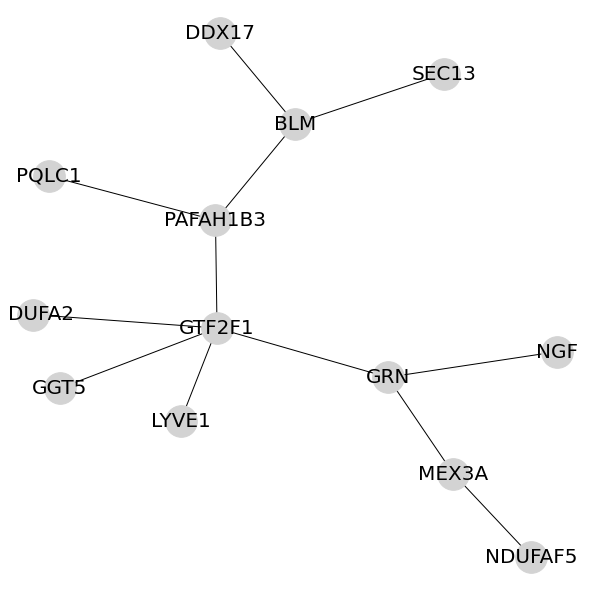

Left bottom corner: PQLC1 [ 83.29466807 350.48630033]
Right top corner: NDUFAF5 [1095.86707787 1150.        ]
stdout>
======= PASS 1    =========
MEX3A
Old (x,y) = 932.3482,976.0572
New (x,y) = 932.3482,976.0572
SEC13
Old (x,y) = 912.8212,135.33194
New (x,y) = 912.8212,135.33194
DDX17
Old (x,y) = 441.6855,50.0
New (x,y) = 441.6855,50.0
GTF2F1
Old (x,y) = 435.78934,669.8821
New (x,y) = 435.78934,669.8821
NDUFA2
Old (x,y) = 50.0,641.5683
New (x,y) = 50.0,641.5683
GRN
Old (x,y) = 794.49536,773.2585
New (x,y) = 794.49536,773.2585
BLM
Old (x,y) = 600.0187,240.43506
New (x,y) = 600.0187,240.43506
PQLC1
Old (x,y) = 83.29467,350.4863
New (x,y) = 83.29467,350.4863
GGT5
Old (x,y) = 105.61804,796.40405
New (x,y) = 105.61804,796.40405
NDUFAF5
Old (x,y) = 1095.8671,1150.0
New (x,y) = 1095.8671,1150.0
LYVE1
Old (x,y) = 359.31876,864.73895
New (x,y) = 359.31876,864.73895
PAFAH1B3
Old (x,y) = 432.54303,443.60104
New (x,y) = 432.54303,443.60104
NGF
Old (x,y) = 1150.0,719.4674
New (x,y) = 1150.0,719.467

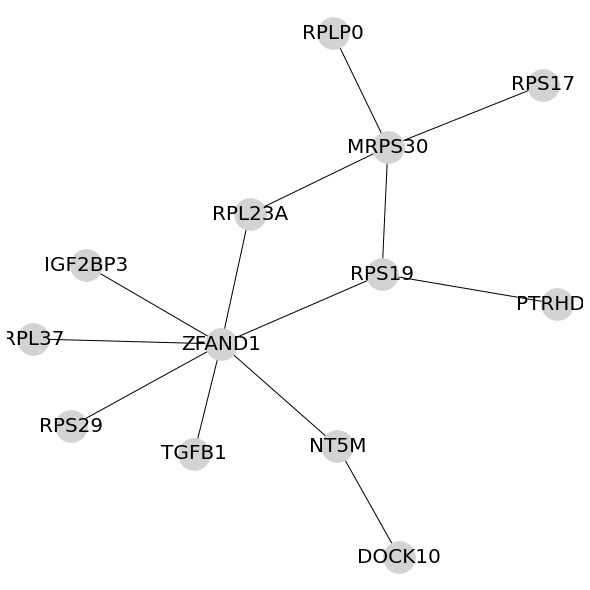

Left bottom corner: IGF2BP3 [161.24850595 538.33099723]
Right top corner: DOCK10 [ 818.62693942 1150.        ]
stdout>
======= PASS 1    =========
DOCK10
Old (x,y) = 818.62695,1150.0
New (x,y) = 818.62695,1150.0
RPS19
Old (x,y) = 782.38336,556.73865
New (x,y) = 782.38336,556.73865
NT5M
Old (x,y) = 688.41345,918.1019
New (x,y) = 688.41345,918.1019
RPLP0
Old (x,y) = 679.0888,50.0
New (x,y) = 679.0888,50.0
IGF2BP3
Old (x,y) = 161.2485,538.331
New (x,y) = 161.2485,538.331
RPL23A
Old (x,y) = 504.16992,429.84677
New (x,y) = 504.16992,429.84677
ZFAND1
Old (x,y) = 444.60095,703.345
New (x,y) = 444.60095,703.345
MRPS30
Old (x,y) = 794.7414,288.9522
New (x,y) = 794.7414,288.9522
RPL37
Old (x,y) = 50.0,692.6875
New (x,y) = 50.0,692.6875
RPS29
Old (x,y) = 129.81985,876.3705
New (x,y) = 129.81985,876.3705
TGFB1
Old (x,y) = 387.54523,933.42535
New (x,y) = 387.54523,933.42535
PTRHD1
Old (x,y) = 1150.0,619.17914
New (x,y) = 1150.0,619.17914
RPS17
Old (x,y) = 1121.4963,158.35056
New (x,y) = 1121.4963,1

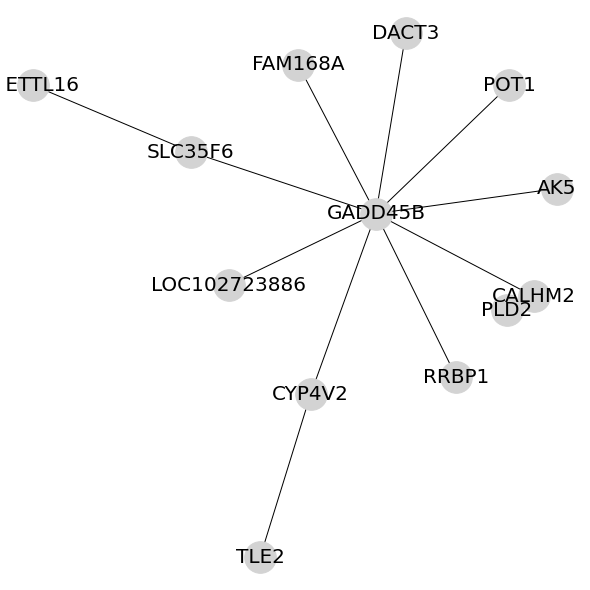

Left bottom corner: METTL16 [ 50.         159.94583837]
Right top corner: RRBP1 [938.6430621 772.9273354]
stdout>
======= PASS 1    =========
CALHM2
Old (x,y) = 1101.064,603.203
New (x,y) = 1101.064,603.203
AK5
Old (x,y) = 1150.0,376.71194
New (x,y) = 1150.0,376.71194
POT1
Old (x,y) = 1049.2177,159.96657
New (x,y) = 1049.2177,159.96657
DACT3
Old (x,y) = 832.53906,50.0
New (x,y) = 832.53906,50.0
FAM168A
Old (x,y) = 605.98834,116.27019
New (x,y) = 605.98834,116.27019
METTL16
Old (x,y) = 50.0,159.94583
New (x,y) = 50.0,159.94583
SLC35F6
Old (x,y) = 380.934,299.724
New (x,y) = 380.934,299.724
LOC102723886
Old (x,y) = 460.42435,578.6794
New (x,y) = 460.42435,578.6794
CYP4V2
Old (x,y) = 632.3739,809.03217
New (x,y) = 632.3739,809.03217
RRBP1
Old (x,y) = 938.64307,772.9273
New (x,y) = 938.64307,772.9273
TLE2
Old (x,y) = 526.68353,1150.0
New (x,y) = 526.68353,1150.0
GADD45B
Old (x,y) = 769.5287,429.41257
New (x,y) = 769.5287,429.41257
PLD2
Old (x,y) = 1044.2024,632.5403
New (x,y) = 1044.2024,6

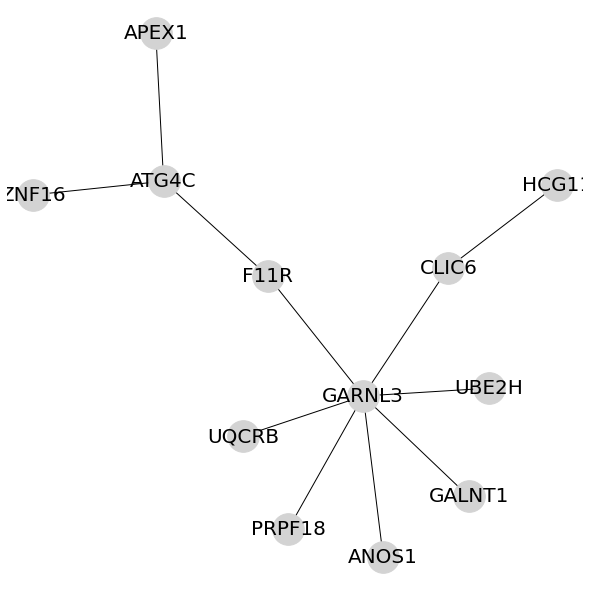

Left bottom corner: APEX1 [307.12578078  50.        ]
Right top corner: GALNT1 [ 964.32531834 1023.59917039]
stdout>
======= PASS 1    =========
GALNT1
Old (x,y) = 964.3253,1023.5992
New (x,y) = 964.3253,1023.5992
UBE2H
Old (x,y) = 1007.08594,796.1501
New (x,y) = 1007.08594,796.1501
APEX1
Old (x,y) = 307.1258,50.0
New (x,y) = 307.1258,50.0
HCG11
Old (x,y) = 1150.0,369.02124
New (x,y) = 1150.0,369.02124
ATG4C
Old (x,y) = 323.61368,361.38315
New (x,y) = 323.61368,361.38315
F11R
Old (x,y) = 542.29736,560.27905
New (x,y) = 542.29736,560.27905
UQCRB
Old (x,y) = 490.5989,896.8642
New (x,y) = 490.5989,896.8642
ZNF16
Old (x,y) = 50.0,390.06238
New (x,y) = 50.0,390.06238
PRPF18
Old (x,y) = 585.2429,1092.4636
New (x,y) = 585.2429,1092.4636
CLIC6
Old (x,y) = 921.93915,542.91833
New (x,y) = 921.93915,542.91833
ANOS1
Old (x,y) = 784.8375,1150.0
New (x,y) = 784.8375,1150.0
GARNL3
Old (x,y) = 742.84406,812.6243
New (x,y) = 742.84406,812.6243
GALNT1->GARNL3
UBE2H->GARNL3
APEX1->ATG4C
HCG11->CLIC6
ATG4

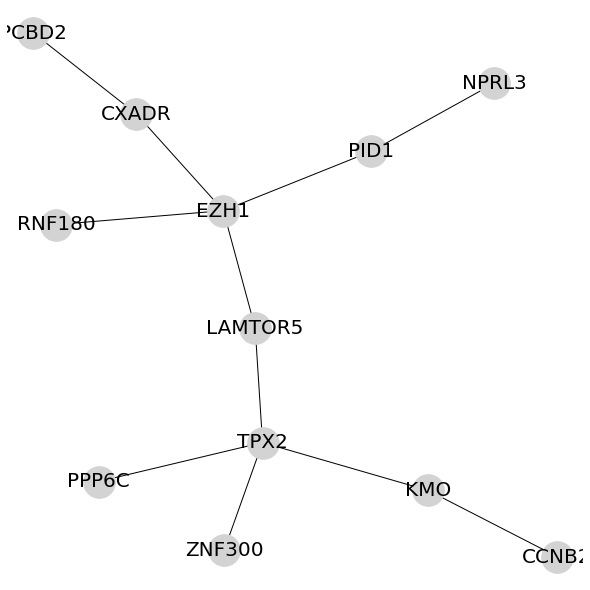

Left bottom corner: PCBD2 [50. 50.]
Right top corner: CCNB2 [1150. 1150.]
stdout>
======= PASS 1    =========
TPX2
Old (x,y) = 531.4059,910.349
New (x,y) = 531.4059,910.349
CCNB2
Old (x,y) = 1150.0,1150.0
New (x,y) = 1150.0,1150.0
CXADR
Old (x,y) = 266.3813,220.08714
New (x,y) = 266.3813,220.08714
NPRL3
Old (x,y) = 1018.5112,155.4271
New (x,y) = 1018.5112,155.4271
PCBD2
Old (x,y) = 50.0,50.0
New (x,y) = 50.0,50.0
PPP6C
Old (x,y) = 187.49405,992.24915
New (x,y) = 187.49405,992.24915
RNF180
Old (x,y) = 97.82326,452.49768
New (x,y) = 97.82326,452.49768
LAMTOR5
Old (x,y) = 515.89795,669.55597
New (x,y) = 515.89795,669.55597
KMO
Old (x,y) = 879.23334,1010.962
New (x,y) = 879.23334,1010.962
ZNF300
Old (x,y) = 451.0782,1135.7952
New (x,y) = 451.0782,1135.7952
EZH1
Old (x,y) = 449.117,423.1836
New (x,y) = 449.117,423.1836
PID1
Old (x,y) = 759.2708,298.90952
New (x,y) = 759.2708,298.90952
TPX2->ZNF300
TPX2->PPP6C
TPX2->LAMTOR5
TPX2->KMO
CCNB2->KMO
CXADR->PCBD2
CXADR->EZH1
NPRL3->PID1
RNF180->EZ

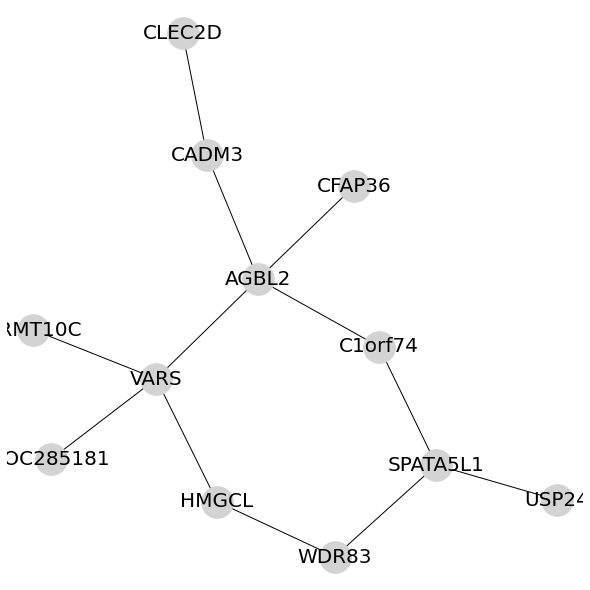

Left bottom corner: CLEC2D [363.48296311  50.        ]
Right top corner: USP24 [1150.         1030.98639774]
stdout>
======= PASS 1    =========
CADM3
Old (x,y) = 414.62033,307.05472
New (x,y) = 414.62033,307.05472
WDR83
Old (x,y) = 683.4312,1150.0
New (x,y) = 683.4312,1150.0
CFAP36
Old (x,y) = 724.1881,371.5833
New (x,y) = 724.1881,371.5833
TRMT10C
Old (x,y) = 50.0,673.7238
New (x,y) = 50.0,673.7238
C1orf74
Old (x,y) = 775.722,708.6414
New (x,y) = 775.722,708.6414
CLEC2D
Old (x,y) = 363.48297,50.0
New (x,y) = 363.48297,50.0
LOC285181
Old (x,y) = 86.80734,945.7435
New (x,y) = 86.80734,945.7435
AGBL2
Old (x,y) = 521.9951,567.0385
New (x,y) = 521.9951,567.0385
HMGCL
Old (x,y) = 435.79767,1034.3518
New (x,y) = 435.79767,1034.3518
VARS
Old (x,y) = 307.90338,776.29175
New (x,y) = 307.90338,776.29175
USP24
Old (x,y) = 1150.0,1030.9865
New (x,y) = 1150.0,1030.9865
SPATA5L1
Old (x,y) = 896.5564,957.5172
New (x,y) = 896.5564,957.5172
CADM3->CLEC2D
CADM3->AGBL2
WDR83->HMGCL
WDR83->SPATA5L1
CFAP3

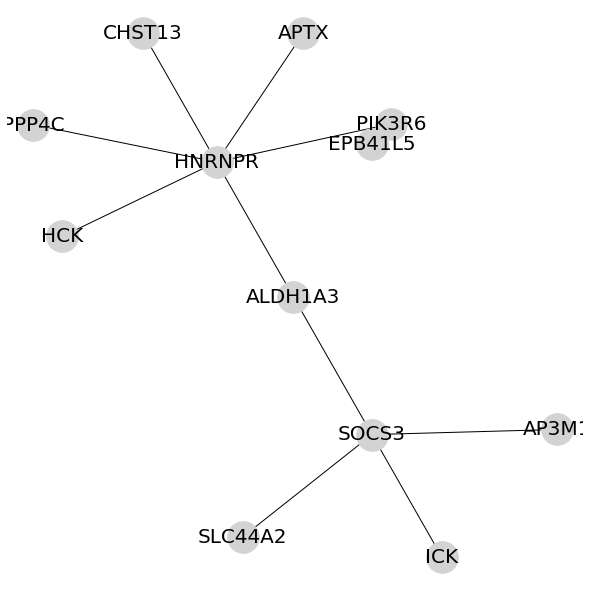

Left bottom corner: PPP4C [ 50.         242.65307578]
Right top corner: ICK [ 907.5252255 1150.       ]
stdout>
======= PASS 1    =========
AP3M1
Old (x,y) = 1150.0,882.9306
New (x,y) = 1150.0,882.9306
APTX
Old (x,y) = 617.39075,50.0
New (x,y) = 617.39075,50.0
EPB41L5
Old (x,y) = 760.43024,283.28717
New (x,y) = 760.43024,283.28717
HNRNPR
Old (x,y) = 434.73218,321.06757
New (x,y) = 434.73218,321.06757
CHST13
Old (x,y) = 280.4533,50.684055
New (x,y) = 280.4533,50.684055
PPP4C
Old (x,y) = 50.0,242.65308
New (x,y) = 50.0,242.65308
SOCS3
Old (x,y) = 761.28375,893.63416
New (x,y) = 761.28375,893.63416
SLC44A2
Old (x,y) = 490.02213,1108.4341
New (x,y) = 490.02213,1108.4341
HCK
Old (x,y) = 111.02739,477.0353
New (x,y) = 111.02739,477.0353
ALDH1A3
Old (x,y) = 596.0226,603.9962
New (x,y) = 596.0226,603.9962
PIK3R6
Old (x,y) = 801.1319,240.85129
New (x,y) = 801.1319,240.85129
ICK
Old (x,y) = 907.5252,1150.0
New (x,y) = 907.5252,1150.0
AP3M1->SOCS3
APTX->HNRNPR
HNRNPR->PPP4C
HNRNPR->PIK3R6
HNRNPR-

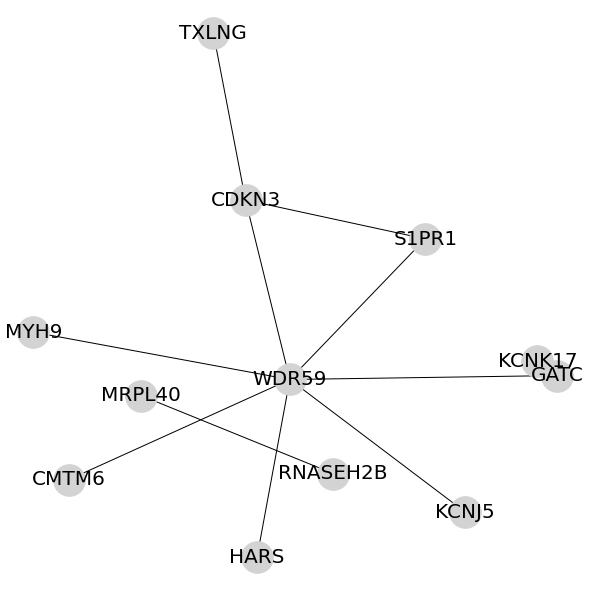

Left bottom corner: TXLNG [427.99771236  50.        ]
Right top corner: KCNJ5 [ 955.88015755 1055.51094251]
stdout>
======= PASS 1    =========
KCNK17
Old (x,y) = 1108.7698,740.02026
New (x,y) = 1108.7698,740.02026
GATC
Old (x,y) = 1150.0,769.64984
New (x,y) = 1150.0,769.64984
WDR59
Old (x,y) = 588.67993,777.9142
New (x,y) = 588.67993,777.9142
CDKN3
Old (x,y) = 495.62924,400.80222
New (x,y) = 495.62924,400.80222
MYH9
Old (x,y) = 50.0,678.44336
New (x,y) = 50.0,678.44336
TXLNG
Old (x,y) = 427.9977,50.0
New (x,y) = 427.9977,50.0
MRPL40
Old (x,y) = 276.37128,811.7184
New (x,y) = 276.37128,811.7184
CMTM6
Old (x,y) = 124.49613,988.20715
New (x,y) = 124.49613,988.20715
HARS
Old (x,y) = 520.04645,1150.0
New (x,y) = 520.04645,1150.0
KCNJ5
Old (x,y) = 955.8802,1055.511
New (x,y) = 955.8802,1055.511
RNASEH2B
Old (x,y) = 679.82904,975.4596
New (x,y) = 679.82904,975.4596
S1PR1
Old (x,y) = 873.13275,482.54242
New (x,y) = 873.13275,482.54242
GATC->WDR59
WDR59->CDKN3
WDR59->MYH9
WDR59->CMTM6
WDR59->H

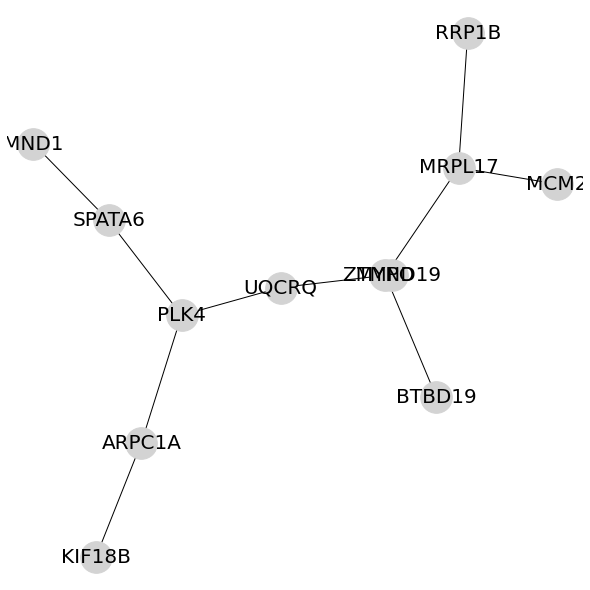

Left bottom corner: MND1 [ 50.         282.48221056]
Right top corner: BTBD19 [896.33289742 814.24907869]
stdout>
======= PASS 1    =========
ZMYND19
Old (x,y) = 802.4309,558.0332
New (x,y) = 802.4309,558.0332
MCM2
Old (x,y) = 1150.0,367.57535
New (x,y) = 1150.0,367.57535
RRP1B
Old (x,y) = 962.38586,50.0
New (x,y) = 962.38586,50.0
UQCRQ
Old (x,y) = 569.2691,584.7599
New (x,y) = 569.2691,584.7599
MND1
Old (x,y) = 50.0,282.4822
New (x,y) = 50.0,282.4822
ARPC1A
Old (x,y) = 276.95282,910.6916
New (x,y) = 276.95282,910.6916
TMPO
Old (x,y) = 789.40216,559.13824
New (x,y) = 789.40216,559.13824
MRPL17
Old (x,y) = 943.27747,332.71823
New (x,y) = 943.27747,332.71823
KIF18B
Old (x,y) = 181.80132,1150.0
New (x,y) = 181.80132,1150.0
PLK4
Old (x,y) = 361.15533,643.0085
New (x,y) = 361.15533,643.0085
SPATA6
Old (x,y) = 207.98283,443.73248
New (x,y) = 207.98283,443.73248
BTBD19
Old (x,y) = 896.3329,814.2491
New (x,y) = 896.3329,814.2491
MCM2->MRPL17
RRP1B->MRPL17
UQCRQ->TMPO
UQCRQ->PLK4
MND1->SPATA6
A

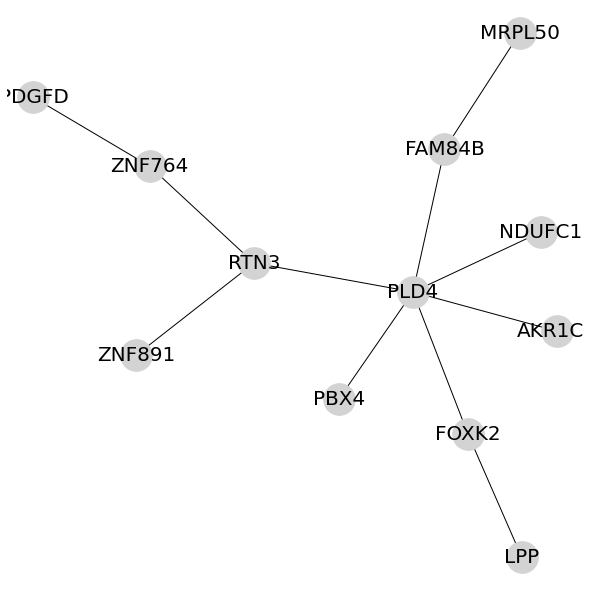

Left bottom corner: PDGFD [ 50.         185.27827578]
Right top corner: LPP [1075.4422411 1150.       ]
stdout>
======= PASS 1    =========
FAM84B
Old (x,y) = 913.5359,294.7399
New (x,y) = 913.5359,294.7399
AKR1C1
Old (x,y) = 1150.0,676.3867
New (x,y) = 1150.0,676.3867
RTN3
Old (x,y) = 513.3628,533.1758
New (x,y) = 513.3628,533.1758
NDUFC1
Old (x,y) = 1115.3914,468.4625
New (x,y) = 1115.3914,468.4625
ZNF764
Old (x,y) = 294.34186,329.90915
New (x,y) = 294.34186,329.90915
MRPL50
Old (x,y) = 1071.8247,50.0
New (x,y) = 1071.8247,50.0
PDGFD
Old (x,y) = 50.0,185.27827
New (x,y) = 50.0,185.27827
LPP
Old (x,y) = 1075.4423,1150.0
New (x,y) = 1075.4423,1150.0
PBX4
Old (x,y) = 691.3309,819.56165
New (x,y) = 691.3309,819.56165
FOXK2
Old (x,y) = 962.5698,891.6658
New (x,y) = 962.5698,891.6658
ZNF891
Old (x,y) = 266.39517,726.56555
New (x,y) = 266.39517,726.56555
PLD4
Old (x,y) = 847.37396,593.9499
New (x,y) = 847.37396,593.9499
FAM84B->MRPL50
FAM84B->PLD4
AKR1C1->PLD4
RTN3->ZNF764
RTN3->ZNF891
RTN3

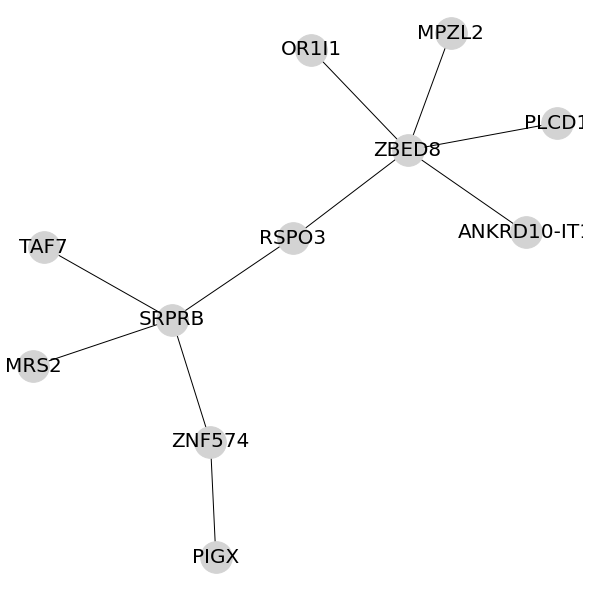

Left bottom corner: TAF7 [ 71.77452706 499.18234906]
Right top corner: PIGX [ 433.28449847 1150.        ]
stdout>
======= PASS 1    =========
PLCD1
Old (x,y) = 1150.0,238.36153
New (x,y) = 1150.0,238.36153
ZBED8
Old (x,y) = 836.2026,296.29126
New (x,y) = 836.2026,296.29126
MPZL2
Old (x,y) = 926.6722,50.0
New (x,y) = 926.6722,50.0
OR1I1
Old (x,y) = 633.7094,84.87518
New (x,y) = 633.7094,84.87518
SRPRB
Old (x,y) = 341.52542,651.94183
New (x,y) = 341.52542,651.94183
RSPO3
Old (x,y) = 594.6111,480.41257
New (x,y) = 594.6111,480.41257
TAF7
Old (x,y) = 71.77453,499.18234
New (x,y) = 71.77453,499.18234
PIGX
Old (x,y) = 433.2845,1150.0
New (x,y) = 433.2845,1150.0
MRS2
Old (x,y) = 50.0,749.7439
New (x,y) = 50.0,749.7439
ANKRD10-IT1
Old (x,y) = 1084.0571,468.39703
New (x,y) = 1084.0571,468.39703
ZNF574
Old (x,y) = 421.88083,908.3673
New (x,y) = 421.88083,908.3673
PLCD1->ZBED8
ZBED8->MPZL2
ZBED8->OR1I1
ZBED8->RSPO3
ZBED8->ANKRD10-IT1
SRPRB->TAF7
SRPRB->ZNF574
SRPRB->RSPO3
SRPRB->MRS2
PIGX->ZNF574

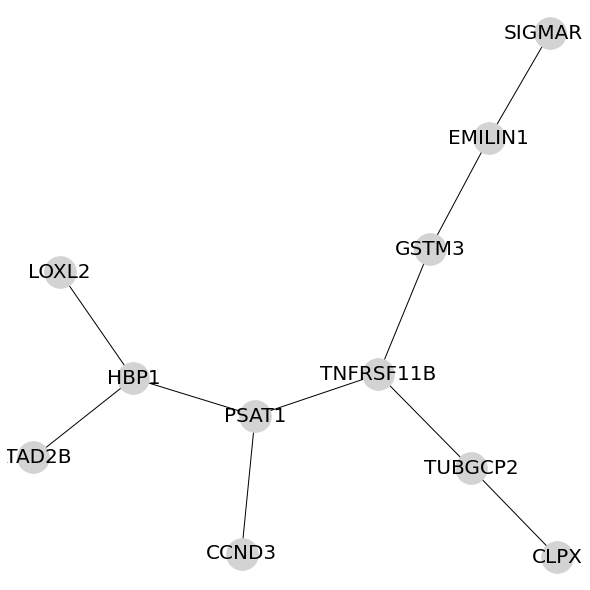

Left bottom corner: LOXL2 [104.89985448 551.29912259]
Right top corner: CLPX [1150. 1150.]
stdout>
======= PASS 1    =========
TNFRSF11B
Old (x,y) = 774.9616,766.607
New (x,y) = 774.9616,766.607
CLPX
Old (x,y) = 1150.0,1150.0
New (x,y) = 1150.0,1150.0
LOXL2
Old (x,y) = 104.89986,551.29913
New (x,y) = 104.89986,551.29913
SIGMAR1
Old (x,y) = 1135.1841,50.0
New (x,y) = 1135.1841,50.0
HBP1
Old (x,y) = 260.04425,775.3879
New (x,y) = 260.04425,775.3879
ATAD2B
Old (x,y) = 50.0,941.702
New (x,y) = 50.0,941.702
EMILIN1
Old (x,y) = 1006.87714,271.1981
New (x,y) = 1006.87714,271.1981
PSAT1
Old (x,y) = 515.8716,854.1415
New (x,y) = 515.8716,854.1415
TUBGCP2
Old (x,y) = 970.1414,964.7079
New (x,y) = 970.1414,964.7079
CCND3
Old (x,y) = 487.21994,1143.6483
New (x,y) = 487.21994,1143.6483
GSTM3
Old (x,y) = 882.83936,503.91443
New (x,y) = 882.83936,503.91443
TNFRSF11B->TUBGCP2
TNFRSF11B->PSAT1
TNFRSF11B->GSTM3
CLPX->TUBGCP2
LOXL2->HBP1
SIGMAR1->EMILIN1
HBP1->PSAT1
HBP1->ATAD2B
EMILIN1->GSTM3
PSAT1->CCN

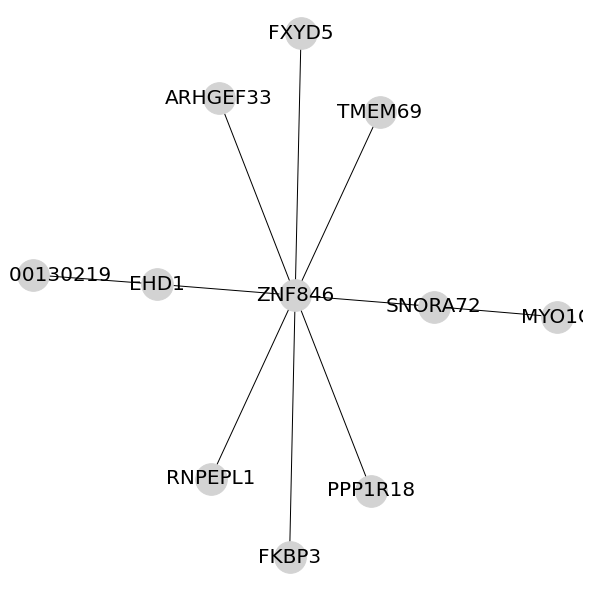

Left bottom corner: LOC100130219 [ 50.         558.08286834]
Right top corner: MYO1G [1150.          646.55761275]
stdout>
======= PASS 1    =========
TMEM69
Old (x,y) = 777.71173,216.98093
New (x,y) = 777.71173,216.98093
MYO1G
Old (x,y) = 1150.0,646.5576
New (x,y) = 1150.0,646.5576
ZNF846
Old (x,y) = 599.9629,601.0332
New (x,y) = 599.9629,601.0332
FXYD5
Old (x,y) = 612.285,50.0
New (x,y) = 612.285,50.0
LOC100130219
Old (x,y) = 50.0,558.0829
New (x,y) = 50.0,558.0829
ARHGEF33
Old (x,y) = 439.08792,187.11394
New (x,y) = 439.08792,187.11394
EHD1
Old (x,y) = 310.23398,577.7944
New (x,y) = 310.23398,577.7944
RNPEPL1
Old (x,y) = 422.07404,986.008
New (x,y) = 422.07404,986.008
SNORA72
Old (x,y) = 890.5946,624.5781
New (x,y) = 890.5946,624.5781
FKBP3
Old (x,y) = 588.1789,1150.0
New (x,y) = 588.1789,1150.0
PPP1R18
Old (x,y) = 759.9873,1011.1354
New (x,y) = 759.9873,1011.1354
TMEM69->ZNF846
MYO1G->SNORA72
ZNF846->FXYD5
ZNF846->ARHGEF33
ZNF846->EHD1
ZNF846->RNPEPL1
ZNF846->SNORA72
ZNF846->FKBP3


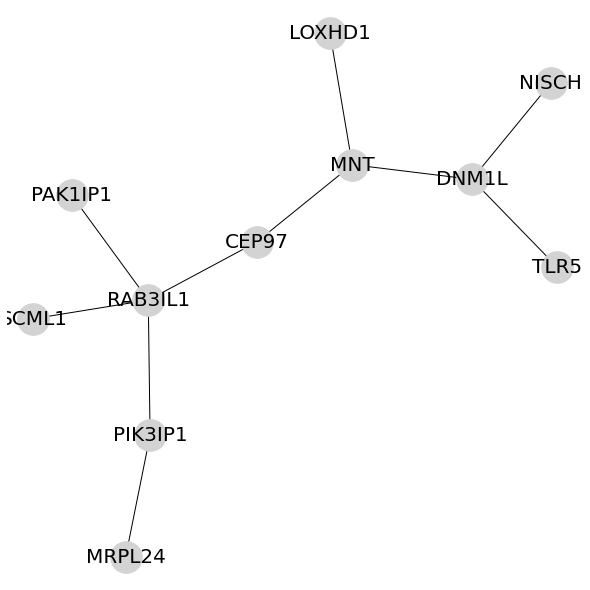

Left bottom corner: PAK1IP1 [130.0824087  390.44044943]
Right top corner: TLR5 [1150.          541.41210857]
stdout>
======= PASS 1    =========
NISCH
Old (x,y) = 1137.1709,154.88113
New (x,y) = 1137.1709,154.88113
DNM1L
Old (x,y) = 971.06616,357.40607
New (x,y) = 971.06616,357.40607
LOXHD1
Old (x,y) = 673.0271,50.0
New (x,y) = 673.0271,50.0
MNT
Old (x,y) = 719.8571,326.62384
New (x,y) = 719.8571,326.62384
PAK1IP1
Old (x,y) = 130.08241,390.44046
New (x,y) = 130.08241,390.44046
CEP97
Old (x,y) = 518.97974,489.1883
New (x,y) = 518.97974,489.1883
SCML1
Old (x,y) = 50.0,650.24445
New (x,y) = 50.0,650.24445
RAB3IL1
Old (x,y) = 291.3238,611.0758
New (x,y) = 291.3238,611.0758
MRPL24
Old (x,y) = 243.92856,1150.0
New (x,y) = 243.92856,1150.0
TLR5
Old (x,y) = 1150.0,541.4121
New (x,y) = 1150.0,541.4121
PIK3IP1
Old (x,y) = 295.16675,895.2562
New (x,y) = 295.16675,895.2562
NISCH->DNM1L
DNM1L->MNT
DNM1L->TLR5
LOXHD1->MNT
MNT->CEP97
PAK1IP1->RAB3IL1
CEP97->RAB3IL1
SCML1->RAB3IL1
RAB3IL1->PIK3IP1
MRP

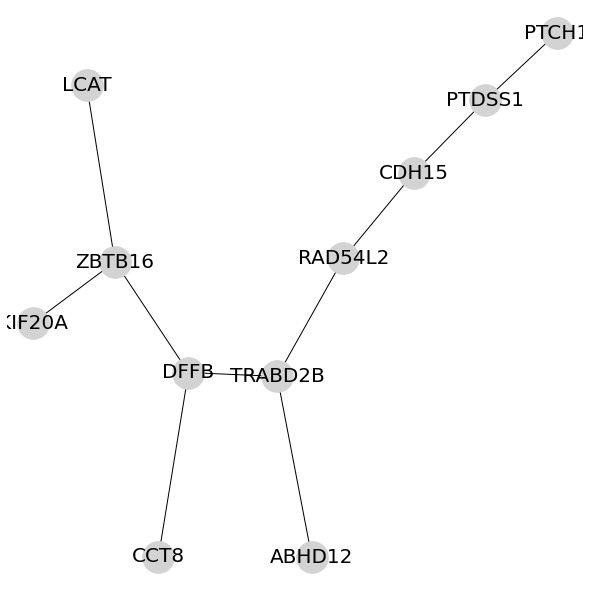

Left bottom corner: LCAT [161.84113118 159.34897564]
Right top corner: ABHD12 [ 634.74956222 1150.        ]
stdout>
======= PASS 1    =========
CDH15
Old (x,y) = 849.27563,344.17325
New (x,y) = 849.27563,344.17325
LCAT
Old (x,y) = 161.84113,159.34897
New (x,y) = 161.84113,159.34897
PTDSS1
Old (x,y) = 999.2684,191.20195
New (x,y) = 999.2684,191.20195
KIF20A
Old (x,y) = 50.0,658.45874
New (x,y) = 50.0,658.45874
ZBTB16
Old (x,y) = 221.34631,530.5189
New (x,y) = 221.34631,530.5189
PTCH1
Old (x,y) = 1150.0,50.0
New (x,y) = 1150.0,50.0
DFFB
Old (x,y) = 375.77365,763.2564
New (x,y) = 375.77365,763.2564
CCT8
Old (x,y) = 312.80997,1149.9507
New (x,y) = 312.80997,1149.9507
TRABD2B
Old (x,y) = 562.0948,771.45874
New (x,y) = 562.0948,771.45874
ABHD12
Old (x,y) = 634.7496,1150.0
New (x,y) = 634.7496,1150.0
RAD54L2
Old (x,y) = 701.36,523.47974
New (x,y) = 701.36,523.47974
CDH15->PTDSS1
CDH15->RAD54L2
LCAT->ZBTB16
PTDSS1->PTCH1
KIF20A->ZBTB16
ZBTB16->DFFB
DFFB->TRABD2B
DFFB->CCT8
TRABD2B->ABHD12
TRAB

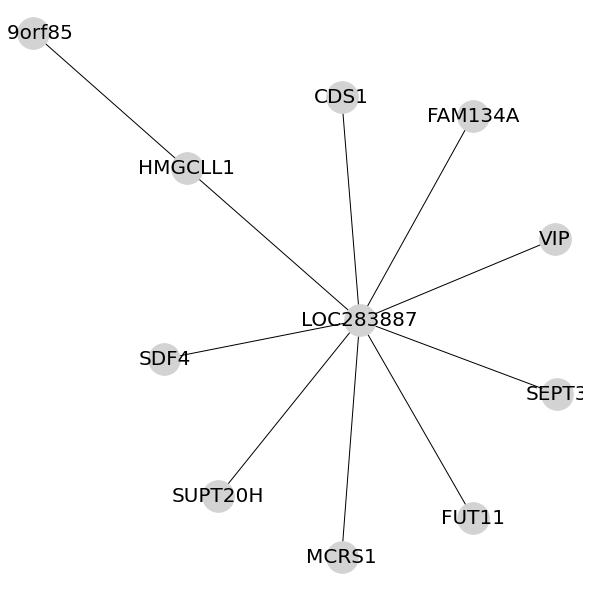

Left bottom corner: C9orf85 [50. 50.]
Right top corner: FUT11 [ 974.12573958 1068.92201744]
stdout>
======= PASS 1    =========
HMGCLL1
Old (x,y) = 372.24033,334.5351
New (x,y) = 372.24033,334.5351
SEPT3
Old (x,y) = 1150.0,808.5006
New (x,y) = 1150.0,808.5006
FAM134A
Old (x,y) = 973.19464,224.52077
New (x,y) = 973.19464,224.52077
CDS1
Old (x,y) = 697.58856,184.63461
New (x,y) = 697.58856,184.63461
SDF4
Old (x,y) = 325.09402,734.51495
New (x,y) = 325.09402,734.51495
C9orf85
Old (x,y) = 50.0,50.0
New (x,y) = 50.0,50.0
SUPT20H
Old (x,y) = 438.0441,1023.37256
New (x,y) = 438.0441,1023.37256
LOC283887
Old (x,y) = 735.5061,653.35974
New (x,y) = 735.5061,653.35974
MCRS1
Old (x,y) = 697.6101,1150.0
New (x,y) = 697.6101,1150.0
FUT11
Old (x,y) = 974.12573,1068.922
New (x,y) = 974.12573,1068.922
VIP
Old (x,y) = 1145.3876,482.3428
New (x,y) = 1145.3876,482.3428
HMGCLL1->LOC283887
HMGCLL1->C9orf85
SEPT3->LOC283887
FAM134A->LOC283887
CDS1->LOC283887
SDF4->LOC283887
SUPT20H->LOC283887
LOC283887->MCRS

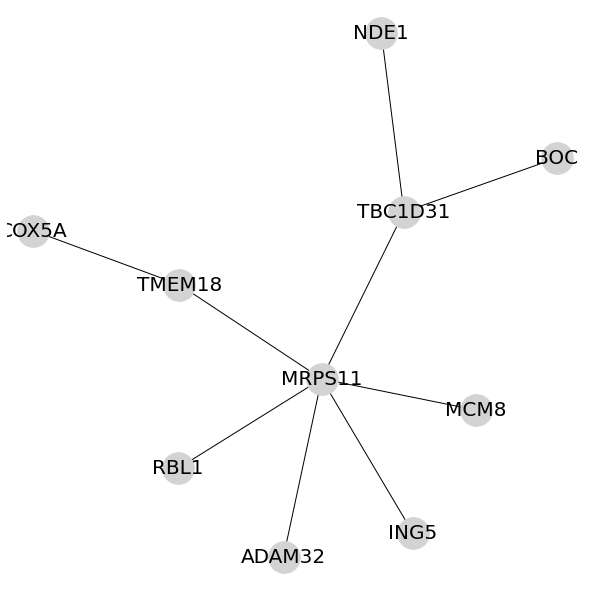

Left bottom corner: COX5A [ 50.        465.4268893]
Right top corner: ING5 [ 847.24569413 1100.10167004]
stdout>
======= PASS 1    =========
ING5
Old (x,y) = 847.24567,1100.1017
New (x,y) = 847.24567,1100.1017
MCM8
Old (x,y) = 978.8563,841.8785
New (x,y) = 978.8563,841.8785
NDE1
Old (x,y) = 781.01544,50.0
New (x,y) = 781.01544,50.0
COX5A
Old (x,y) = 50.0,465.42688
New (x,y) = 50.0,465.42688
MRPS11
Old (x,y) = 655.5584,776.54
New (x,y) = 655.5584,776.54
RBL1
Old (x,y) = 354.25238,964.4899
New (x,y) = 354.25238,964.4899
TBC1D31
Old (x,y) = 828.3778,426.04855
New (x,y) = 828.3778,426.04855
TMEM18
Old (x,y) = 356.8195,578.7252
New (x,y) = 356.8195,578.7252
ADAM32
Old (x,y) = 575.46436,1150.0
New (x,y) = 575.46436,1150.0
BOC
Old (x,y) = 1150.0,312.4467
New (x,y) = 1150.0,312.4467
ING5->MRPS11
MCM8->MRPS11
NDE1->TBC1D31
COX5A->TMEM18
MRPS11->RBL1
MRPS11->TBC1D31
MRPS11->TMEM18
MRPS11->ADAM32
TBC1D31->BOC
ING5->MRPS11
MCM8->MRPS11
NDE1->TBC1D31
COX5A->TMEM18
MRPS11->RBL1
MRPS11->TBC1D31
MRPS1

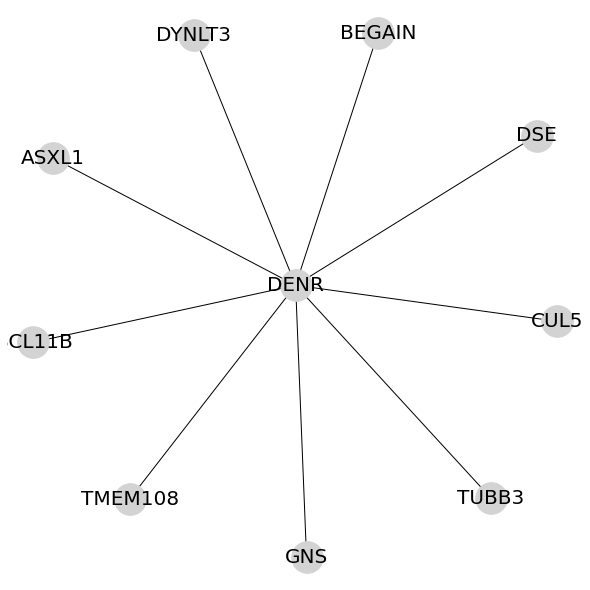

Left bottom corner: ASXL1 [ 91.11828737 312.50951503]
Right top corner: TUBB3 [1010.35523973 1026.10082547]
stdout>
======= PASS 1    =========
CUL5
Old (x,y) = 1150.0,655.68414
New (x,y) = 1150.0,655.68414
DSE
Old (x,y) = 1106.9418,265.42435
New (x,y) = 1106.9418,265.42435
BEGAIN
Old (x,y) = 773.9856,50.0
New (x,y) = 773.9856,50.0
DYNLT3
Old (x,y) = 387.34937,53.837513
New (x,y) = 387.34937,53.837513
ASXL1
Old (x,y) = 91.118286,312.50952
New (x,y) = 91.118286,312.50952
BCL11B
Old (x,y) = 50.0,699.6617
New (x,y) = 50.0,699.6617
TMEM108
Old (x,y) = 253.06738,1028.1897
New (x,y) = 253.06738,1028.1897
DENR
Old (x,y) = 600.8803,580.02466
New (x,y) = 600.8803,580.02466
GNS
Old (x,y) = 623.7513,1150.0
New (x,y) = 623.7513,1150.0
TUBB3
Old (x,y) = 1010.3552,1026.1008
New (x,y) = 1010.3552,1026.1008
CUL5->DENR
DSE->DENR
BEGAIN->DENR
DYNLT3->DENR
ASXL1->DENR
BCL11B->DENR
TMEM108->DENR
DENR->GNS
DENR->TUBB3
CUL5->DENR
DSE->DENR
BEGAIN->DENR
DYNLT3->DENR
ASXL1->DENR
BCL11B->DENR
TMEM108->DENR
DEN

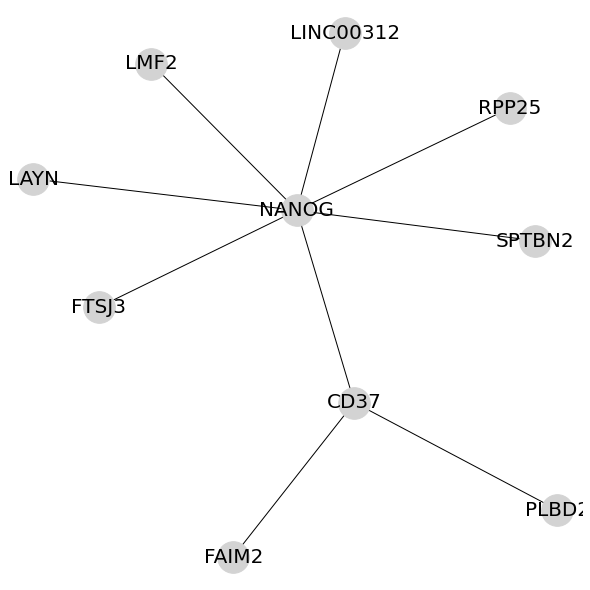

Left bottom corner: LAYN [ 50.         356.71356858]
Right top corner: PLBD2 [1150.         1051.48321385]
stdout>
======= PASS 1    =========
SPTBN2
Old (x,y) = 1103.4608,486.26837
New (x,y) = 1103.4608,486.26837
RPP25
Old (x,y) = 1050.2997,208.1265
New (x,y) = 1050.2997,208.1265
LINC00312
Old (x,y) = 703.7454,50.0
New (x,y) = 703.7454,50.0
LMF2
Old (x,y) = 298.01556,114.316795
New (x,y) = 298.01556,114.316795
LAYN
Old (x,y) = 50.0,356.71356
New (x,y) = 50.0,356.71356
NANOG
Old (x,y) = 603.64453,422.6574
New (x,y) = 603.64453,422.6574
FTSJ3
Old (x,y) = 186.82086,626.2433
New (x,y) = 186.82086,626.2433
FAIM2
Old (x,y) = 469.771,1150.0
New (x,y) = 469.771,1150.0
CD37
Old (x,y) = 724.1488,826.3124
New (x,y) = 724.1488,826.3124
PLBD2
Old (x,y) = 1150.0,1051.4832
New (x,y) = 1150.0,1051.4832
SPTBN2->NANOG
RPP25->NANOG
LINC00312->NANOG
LMF2->NANOG
LAYN->NANOG
NANOG->FTSJ3
NANOG->CD37
FAIM2->CD37
CD37->PLBD2
SPTBN2->NANOG
RPP25->NANOG
LINC00312->NANOG
LMF2->NANOG
LAYN->NANOG
NANOG->FTSJ3
NAN

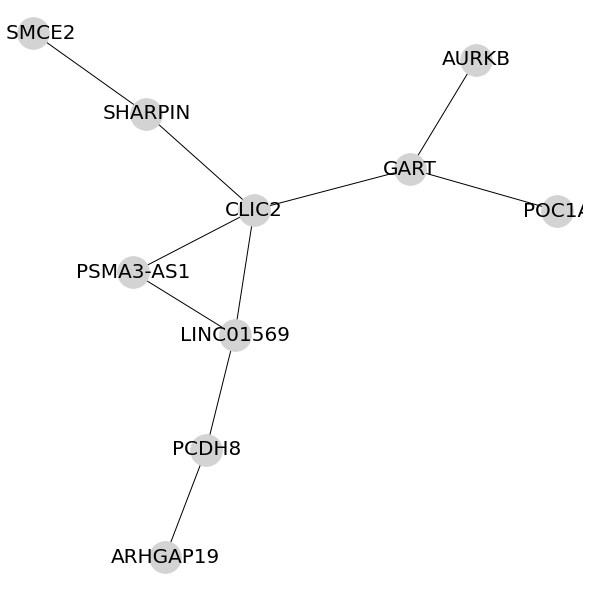

Left bottom corner: NSMCE2 [50. 50.]
Right top corner: POC1A [1150.          423.30158523]
stdout>
======= PASS 1    =========
PCDH8
Old (x,y) = 413.029,925.16034
New (x,y) = 413.029,925.16034
NSMCE2
Old (x,y) = 50.0,50.0
New (x,y) = 50.0,50.0
AURKB
Old (x,y) = 979.89844,105.70873
New (x,y) = 979.89844,105.70873
SHARPIN
Old (x,y) = 287.39026,219.15225
New (x,y) = 287.39026,219.15225
CLIC2
Old (x,y) = 513.83704,421.3418
New (x,y) = 513.83704,421.3418
LINC01569
Old (x,y) = 472.76514,684.5171
New (x,y) = 472.76514,684.5171
GART
Old (x,y) = 841.05554,335.24335
New (x,y) = 841.05554,335.24335
PSMA3-AS1
Old (x,y) = 259.89694,552.96533
New (x,y) = 259.89694,552.96533
ARHGAP19
Old (x,y) = 327.10928,1150.0
New (x,y) = 327.10928,1150.0
POC1A
Old (x,y) = 1150.0,423.30157
New (x,y) = 1150.0,423.30157
PCDH8->LINC01569
PCDH8->ARHGAP19
NSMCE2->SHARPIN
AURKB->GART
SHARPIN->CLIC2
CLIC2->LINC01569
CLIC2->GART
CLIC2->PSMA3-AS1
LINC01569->PSMA3-AS1
GART->POC1A
PCDH8->LINC01569
PCDH8->ARHGAP19
NSMCE2->SHAR

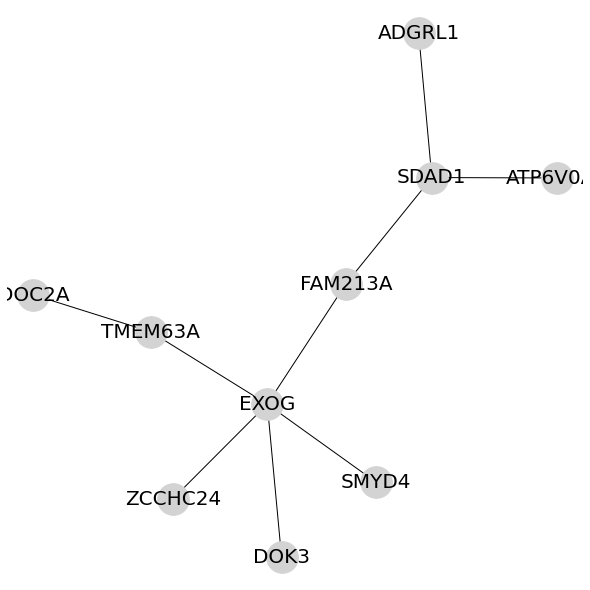

Left bottom corner: DOC2A [ 50.         600.04184448]
Right top corner: SMYD4 [769.08198463 993.06250072]
stdout>
======= PASS 1    =========
TMEM63A
Old (x,y) = 296.2666,677.6073
New (x,y) = 296.2666,677.6073
ATP6V0A2
Old (x,y) = 1150.0,354.5792
New (x,y) = 1150.0,354.5792
ADGRL1
Old (x,y) = 859.2747,50.0
New (x,y) = 859.2747,50.0
DOC2A
Old (x,y) = 50.0,600.0419
New (x,y) = 50.0,600.0419
EXOG
Old (x,y) = 541.3376,829.72516
New (x,y) = 541.3376,829.72516
FAM213A
Old (x,y) = 706.7162,576.7339
New (x,y) = 706.7162,576.7339
ZCCHC24
Old (x,y) = 343.2624,1028.3284
New (x,y) = 343.2624,1028.3284
SDAD1
Old (x,y) = 887.0968,353.69073
New (x,y) = 887.0968,353.69073
DOK3
Old (x,y) = 571.25806,1150.0
New (x,y) = 571.25806,1150.0
SMYD4
Old (x,y) = 769.082,993.0625
New (x,y) = 769.082,993.0625
TMEM63A->DOC2A
TMEM63A->EXOG
ATP6V0A2->SDAD1
ADGRL1->SDAD1
EXOG->FAM213A
EXOG->ZCCHC24
EXOG->SMYD4
EXOG->DOK3
FAM213A->SDAD1
TMEM63A->DOC2A
TMEM63A->EXOG
ATP6V0A2->SDAD1
ADGRL1->SDAD1
EXOG->FAM213A
EXOG->ZCCH

In [34]:
## Batch conversion

#folder = '/mnt/c/Datas/iPaediatricCure/Networks/Summa_Forget_subnetworks_n10_inflation_2/'
folder = '/mnt/c/Users/zinovyev/Google Drive/iPC_CURIE/Networks/Ewing_Postel_Vinay_RNAseq/'
path_2_binom = '/mnt/c/MyPrograms/BiNoM2014/BiNoM_all.jar'

files_in_folder = [f for f in listdir(folder) if isfile(join(folder, f))]
print(files_in_folder)
for f in files_in_folder:
    if f.endswith('.cyjs'):
        convert_cyjs2celldesigner(folder,f,path_2_binom,final_name=f.replace('Ewing','ES'))


In [31]:
## Batch upload

import navicell_map_upload
from navicell_map_upload import Client
import os.path
from os import path
import pandas as pd
import time

folder = '/mnt/c/Users/zinovyev/Google Drive/iPC_CURIE/Networks/MB_Forget_RNASeq/'
client = Client('andrei.zinovyev@curie.fr', 'Curie2021')

tags_base = ['ipc','medulloblastoma,rnaseq','data-driven network']

files_in_folder = [f for f in listdir(folder) if isfile(join(folder, f))]

annotation_file = folder+'Functional_enrichment_of_modules.csv'
module_annotation = {}
if path.exists(annotation_file):
    print('Annotation found, parsing...')
    df = pd.read_csv(annotation_file)
    module_names = list(df['Module_name'])
    for index, row in df.iterrows():
        mn = str(row['Module_name'])
        fn = str(row['Function'])
        pv = str(row['Pvalue'])
        #print(mn,fn,pv)        
        if not 'No results to show' in fn:
            tags = []
            fns = fn.replace('  ','@').split('@')
            pvs = pv.replace('  ','@').split('@')
            for i,ff in enumerate(fns):
                if not ff=='NA':
                    pv1 = float(pvs[i])
                    if pv1<0.005:
                        tags.append(ff)
            if len(tags)>0:
                module_annotation[mn] =tags
            
for f in files_in_folder:
    if f.endswith('.xml'):
        name = f[:-4]
        print(name)
        cd_filename = folder+f
        image_filename = folder+f[:-4]+'.png'
        tags = tags_base.copy()
        if name in module_annotation:
            tags = tags + module_annotation[name]
        print(tags)
        client.uploadMap(name, cd_filename, tags=tags, is_async=True, image_filename=image_filename)
        time.sleep(1.0)


Annotation found, parsing...
{'MB_Forget_RNAseq_module02': ['BORC complex'], 'MB_Forget_RNASeq_module03': ['ERBB3-SPG1 complex', 'ERBB2-SPG1 complex', 'miR-222 in Exercise-Induced Cardiac Growth'], 'MB_Forget_RNASeq_module06': ['hsa-miR-6737-3p', 'hsa-miR-7157-3p', 'hsa-miR-5008-3p'], 'MB_Forget_RNASeq_module07': ['Endosomal targeting complex (VIPAS39-VPS33B)'], 'MB_Forget_RNASeq_module15': ['ARHGEF7-GIT2-PAK1 complex'], 'MB_Forget_RNASeq_module25': ['trans-Golgi network'], 'MB_Forget_RNASeq_module27': ['histone demethylase activity', 'protein demethylase activity', 'demethylase activity'], 'MB_Forget_RNASeq_module33': ['DGKZ-RASGRP1-HRAS complex'], 'MB_Forget_RNASeq_module35': ['Endoderm Differentiation', 'BCL6-ZBTB17 complex', 'MYC-DNMT3A-ZBTB17 complex'], 'MB_Forget_RNASeq_module37': ['Sarcoglycan-sarcospan complex SG-SPN'], 'MB_Forget_RNASeq_module38': ['tubulin N-acetyltransferase activity'], 'MB_Forget_RNASeq_module40': ['Vibrio cholerae infection', 'EIF4A3-MLN51 complex'], 'MB_F

In [9]:
maps = client.getMaps()
for mp in maps:
    print(mp['name'])

Adaptative Immunity
Innate Immunity
NFkB
Telomere maintenance
